In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv1DTranspose
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

2023-10-09 08:10:33.346705: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Configure Matplotlib

Choose a matplotlib style sheet to match your browser theme (dark or light)

Increase the figure size to match the notebook width.

Set the graph colour variables.

In [2]:
#style_sheet = 'dark_background' # dark theme
#style_sheet = 'default'         # light theme
#plt.style.use(style_sheet)

plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.dpi'] = 200

In [3]:
class BestEpoch(Callback):
  def __init__(self, metric='val_loss', mode='min'):
    super().__init__()
    self.metric = metric
    self.mode = mode
    

  def on_train_begin(self, logs={}):
    self.bestEpoch = 0
    if self.mode == 'min':
      self.bestLoss = 1e8
    else:
      self.bestLoss = -1e8

  def on_epoch_end(self, epoch, logs={}):
    valLoss = logs.get(self.metric)
    if self.mode == 'min' and valLoss < self.bestLoss:
      self.bestLoss = valLoss
      self.bestEpoch = epoch+1
    elif valLoss > self.bestLoss:
      self.bestLoss = valLoss
      self.bestEpoch = epoch+1

  def get_best_epoch(self):
    return self.bestEpoch



In [4]:
class PlotLoss(Callback):
  def __init__(self, metric='val_loss'):
    super().__init__()
    self.metric = metric
    matplotlib.interactive(True)
    
  def __del__(self):
    plt.close('all')

  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.loss_y = []
    self.metric_y = []
    self.logs = []
    self.fig = plt.figure()

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)
    self.loss_y.append(logs.get('loss'))
    self.metric_y.append(logs.get(self.metric))
    self.i += 1

    #clear_output(wait=False)
    plt.clf()
    plt.plot(self.x, self.loss_y, label="loss")
    plt.plot(self.x, self.metric_y, label=self.metric)
    plt.legend()
    plt.show(block=False);
    plt.draw();
    plt.pause(0.05)
    print(logs)


In [5]:
with open('train.dat', 'rb') as f:
    train_X = np.load(f)
    train_Y = np.load(f)

In [6]:
print(train_X.shape, train_Y.shape)

(1442, 4320, 53) (1442, 1)


In [7]:
with open('valid.dat', 'rb') as f:
    valid_X = np.load(f)
    valid_Y = np.load(f)

In [8]:
print(valid_X.shape, valid_Y.shape)

(117, 4320, 53) (117, 1)


In [9]:
#train_mean = np.mean(train_X, axis=(0,1))
#train_X[:,:] -= train_mean
#train_std = np.std(train_X, axis=(0,1))
#train_X[:,:] /= train_std
#valid_X[:,:] -= train_mean
#valid_X[:,:] /= train_std
min = np.min(train_X, axis=(0,1))
max = np.max(train_X, axis=(0,1))
train_X[:,:] = [(val - min) / (max - min) for val in train_X[:,:]]
valid_X[:,:] = [(val - min) / (max - min) for val in valid_X[:,:]]

In [10]:
with open('train.stats', 'wb') as f:
    np.save(f, min)
    np.save(f, max)

In [11]:
#nan=np.argwhere(np.isnan(train_Y))
#print(nan.shape)

In [12]:
epochs=100
batch_size=32
learning_rate=1e-3

In [13]:
#model = Sequential()
#model.add(Flatten())
#model.add(Dense(2048, activation='relu'))
#model.add(Dense(1024, activation='relu'))
#model.add(Dense(512, activation='relu'))
#model.add(Dense(1, activation='linear'))

In [14]:
model = Sequential()
model.add(Conv1D(32, 5, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 5, activation='relu'))
#model.add(BatchNormalization())
model.add(Conv1D(128, 5, activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv1D(256, 5, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
#model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

2023-10-09 08:10:37.467703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 08:10:37.490664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 08:10:37.490842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 08:10:37.491255: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, r

In [15]:
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

In [16]:
filepath="models/dscovrmatic-conv1d-v1-e{epoch:d}"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')
plotloss = PlotLoss()
bestepoch = BestEpoch()
earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=10, min_delta=1e-5)
#callbacks = [checkpoint, plotloss, bestepoch, earlystop]
callbacks = [checkpoint, plotloss, bestepoch]


Epoch 1/100


2023-10-09 08:10:40.257950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-10-09 08:10:40.378846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:648] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-09 08:10:40.401301: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f468859b6d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-09 08:10:40.401338: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-10-09 08:10:40.405148: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-09 08:10:40.500297: I tensorflow/compiler/jit/xla_compilation_cache.cc:480] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

46/46 [==============================] - ETA: 0s - loss: 16223.7617 - mse: 16223.7617
Epoch 1: val_loss improved from inf to 3.07375, saving model to models/dscovrmatic-conv1d-v1-e1
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python

INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e1/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e1/assets


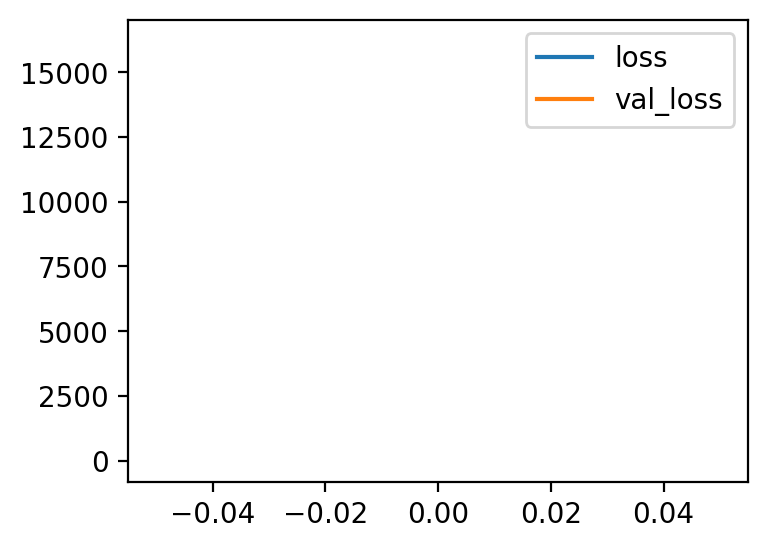

<Figure size 800x600 with 0 Axes>

{'loss': 16223.76171875, 'mse': 16223.76171875, 'val_loss': 3.0737545490264893, 'val_mse': 3.0737545490264893}
46/46 [==============================] - 6s 86ms/step - loss: 16223.7617 - mse: 16223.7617 - val_loss: 3.0738 - val_mse: 3.0738
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 1.3841 - mse: 1.3841
Epoch 2: val_loss did not improve from 3.07375


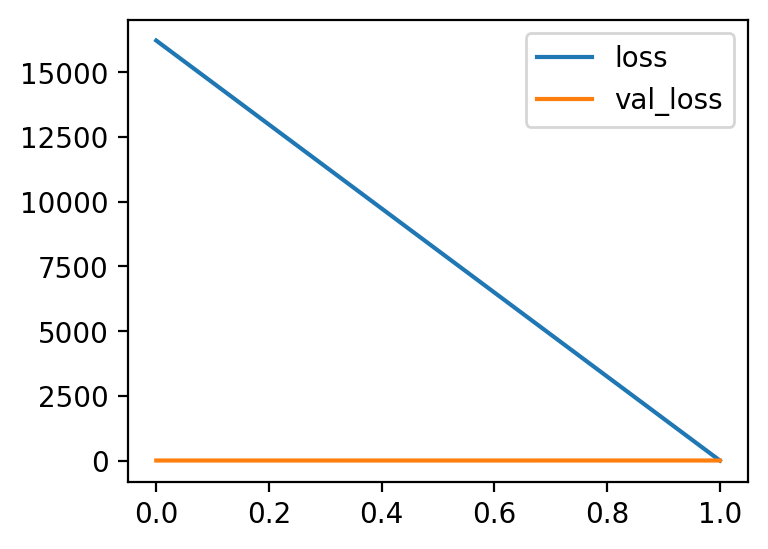

<Figure size 800x600 with 0 Axes>

{'loss': 1.38407564163208, 'mse': 1.38407564163208, 'val_loss': 3.5361170768737793, 'val_mse': 3.5361170768737793}
46/46 [==============================] - 1s 28ms/step - loss: 1.3841 - mse: 1.3841 - val_loss: 3.5361 - val_mse: 3.5361
Epoch 3/100
45/46 [============================>.] - ETA: 0s - loss: 0.9324 - mse: 0.9324
Epoch 3: val_loss did not improve from 3.07375


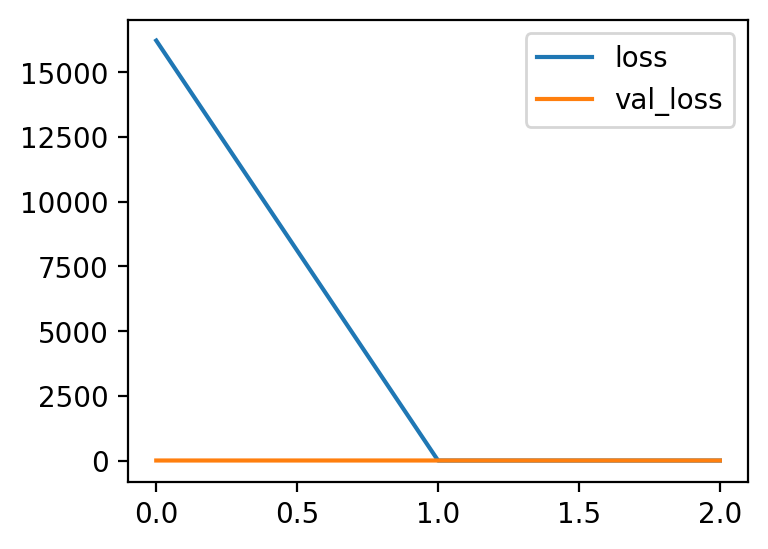

<Figure size 800x600 with 0 Axes>

{'loss': 0.9326464533805847, 'mse': 0.9326464533805847, 'val_loss': 3.5810630321502686, 'val_mse': 3.5810630321502686}
46/46 [==============================] - 1s 27ms/step - loss: 0.9326 - mse: 0.9326 - val_loss: 3.5811 - val_mse: 3.5811
Epoch 4/100
46/46 [==============================] - ETA: 0s - loss: 0.8424 - mse: 0.8424
Epoch 4: val_loss did not improve from 3.07375


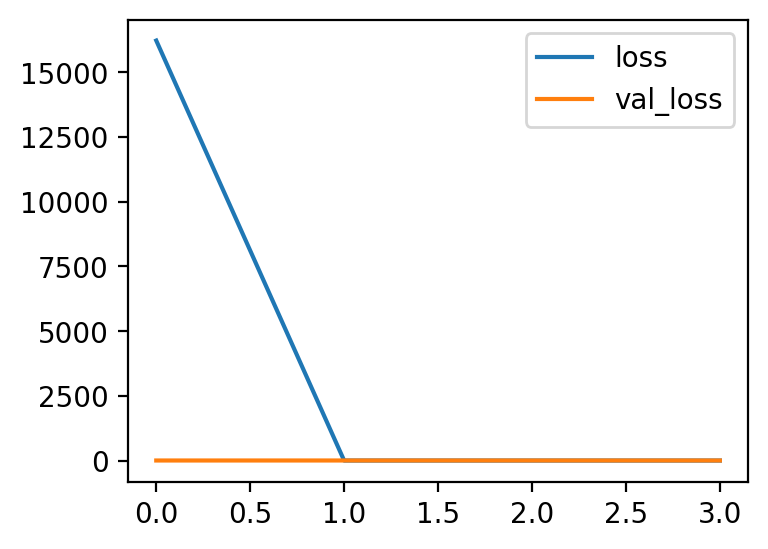

<Figure size 800x600 with 0 Axes>

{'loss': 0.8423947691917419, 'mse': 0.8423947691917419, 'val_loss': 3.198641777038574, 'val_mse': 3.198641777038574}
46/46 [==============================] - 1s 27ms/step - loss: 0.8424 - mse: 0.8424 - val_loss: 3.1986 - val_mse: 3.1986
Epoch 5/100
46/46 [==============================] - ETA: 0s - loss: 0.8150 - mse: 0.8150
Epoch 5: val_loss improved from 3.07375 to 2.74195, saving model to models/dscovrmatic-conv1d-v1-e5
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e5/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e5/assets


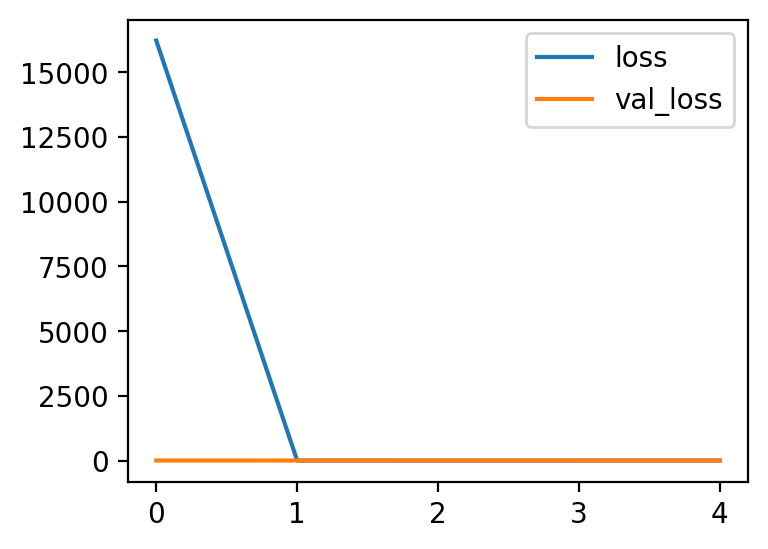

<Figure size 800x600 with 0 Axes>

{'loss': 0.8150213956832886, 'mse': 0.8150213956832886, 'val_loss': 2.7419519424438477, 'val_mse': 2.7419519424438477}
46/46 [==============================] - 3s 71ms/step - loss: 0.8150 - mse: 0.8150 - val_loss: 2.7420 - val_mse: 2.7420
Epoch 6/100
46/46 [==============================] - ETA: 0s - loss: 0.7618 - mse: 0.7618
Epoch 6: val_loss improved from 2.74195 to 2.09241, saving model to models/dscovrmatic-conv1d-v1-e6
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e6/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e6/assets


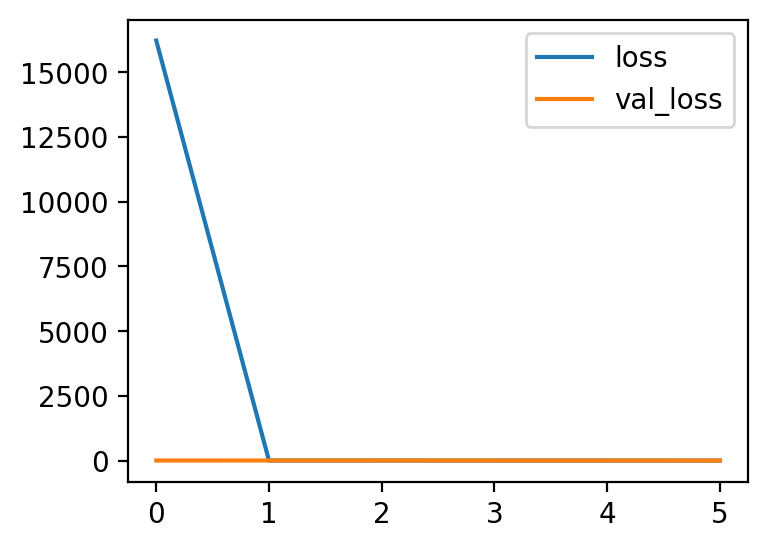

<Figure size 800x600 with 0 Axes>

{'loss': 0.7618278861045837, 'mse': 0.7618278861045837, 'val_loss': 2.0924148559570312, 'val_mse': 2.0924148559570312}
46/46 [==============================] - 3s 72ms/step - loss: 0.7618 - mse: 0.7618 - val_loss: 2.0924 - val_mse: 2.0924
Epoch 7/100
46/46 [==============================] - ETA: 0s - loss: 0.7668 - mse: 0.7668
Epoch 7: val_loss improved from 2.09241 to 1.75478, saving model to models/dscovrmatic-conv1d-v1-e7
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e7/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e7/assets


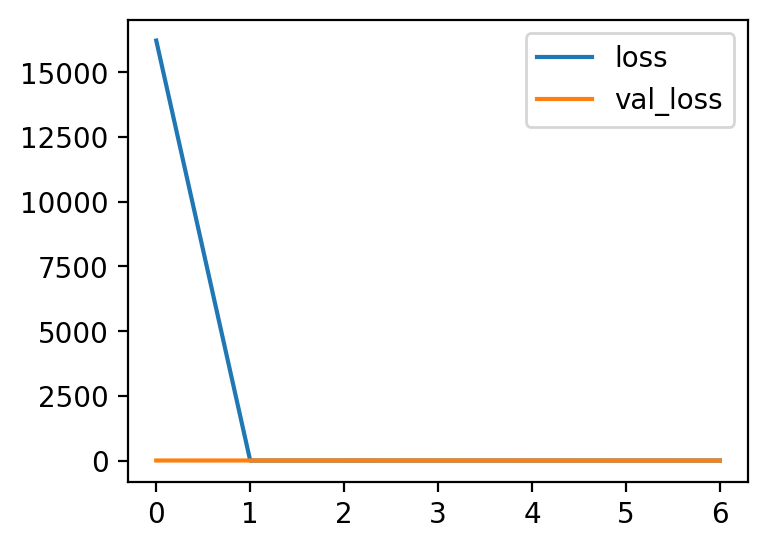

<Figure size 800x600 with 0 Axes>

{'loss': 0.7668271064758301, 'mse': 0.7668271064758301, 'val_loss': 1.7547844648361206, 'val_mse': 1.7547844648361206}
46/46 [==============================] - 3s 75ms/step - loss: 0.7668 - mse: 0.7668 - val_loss: 1.7548 - val_mse: 1.7548
Epoch 8/100
46/46 [==============================] - ETA: 0s - loss: 0.7524 - mse: 0.7524
Epoch 8: val_loss improved from 1.75478 to 1.58985, saving model to models/dscovrmatic-conv1d-v1-e8
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e8/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e8/assets


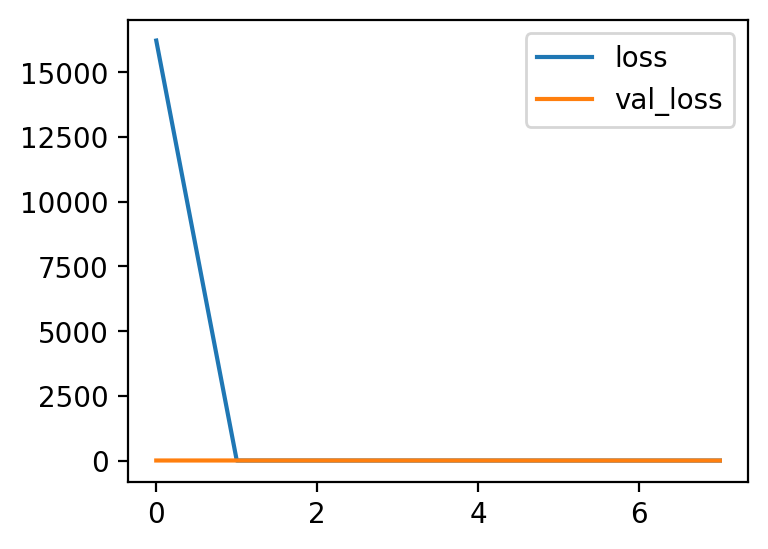

<Figure size 800x600 with 0 Axes>

{'loss': 0.7523842453956604, 'mse': 0.7523842453956604, 'val_loss': 1.589853286743164, 'val_mse': 1.589853286743164}
46/46 [==============================] - 3s 71ms/step - loss: 0.7524 - mse: 0.7524 - val_loss: 1.5899 - val_mse: 1.5899
Epoch 9/100
46/46 [==============================] - ETA: 0s - loss: 0.8524 - mse: 0.8524
Epoch 9: val_loss improved from 1.58985 to 1.24943, saving model to models/dscovrmatic-conv1d-v1-e9
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e9/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e9/assets


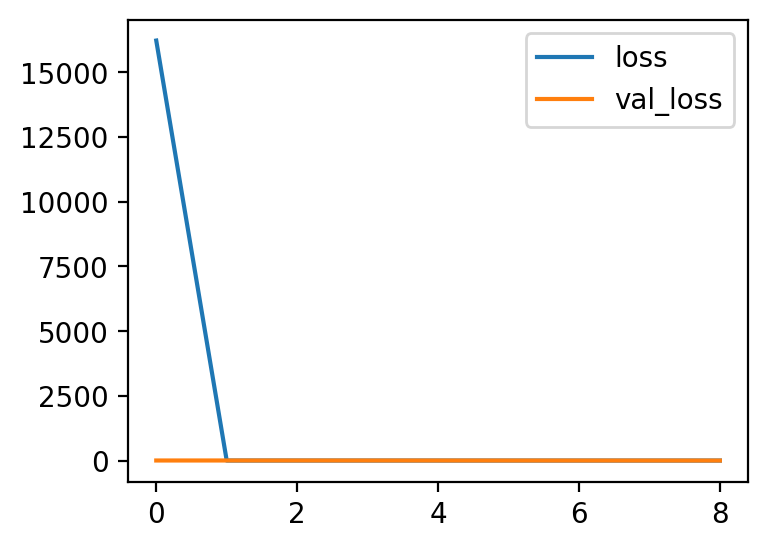

<Figure size 800x600 with 0 Axes>

{'loss': 0.8523845076560974, 'mse': 0.8523845076560974, 'val_loss': 1.2494312524795532, 'val_mse': 1.2494312524795532}
46/46 [==============================] - 3s 72ms/step - loss: 0.8524 - mse: 0.8524 - val_loss: 1.2494 - val_mse: 1.2494
Epoch 10/100
46/46 [==============================] - ETA: 0s - loss: 0.7503 - mse: 0.7503
Epoch 10: val_loss did not improve from 1.24943


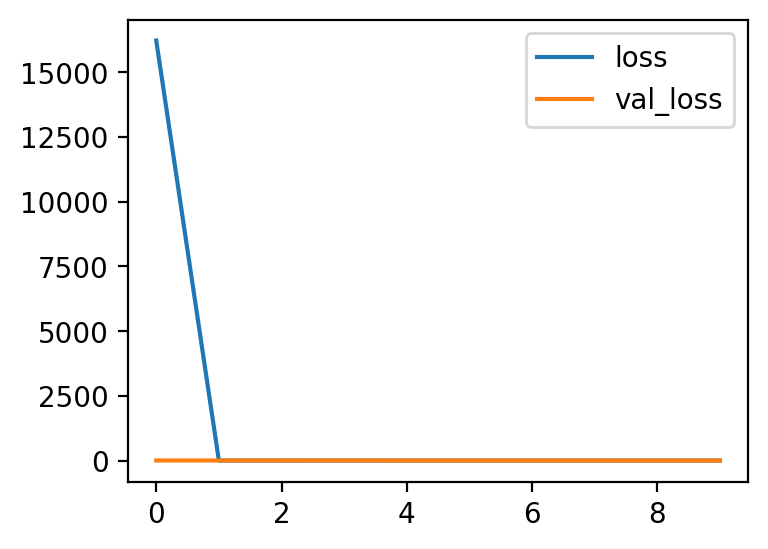

<Figure size 800x600 with 0 Axes>

{'loss': 0.7502544522285461, 'mse': 0.7502544522285461, 'val_loss': 1.4570132493972778, 'val_mse': 1.4570132493972778}
46/46 [==============================] - 1s 27ms/step - loss: 0.7503 - mse: 0.7503 - val_loss: 1.4570 - val_mse: 1.4570
Epoch 11/100
46/46 [==============================] - ETA: 0s - loss: 0.8209 - mse: 0.8209
Epoch 11: val_loss improved from 1.24943 to 0.97060, saving model to models/dscovrmatic-conv1d-v1-e11
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e11/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e11/assets


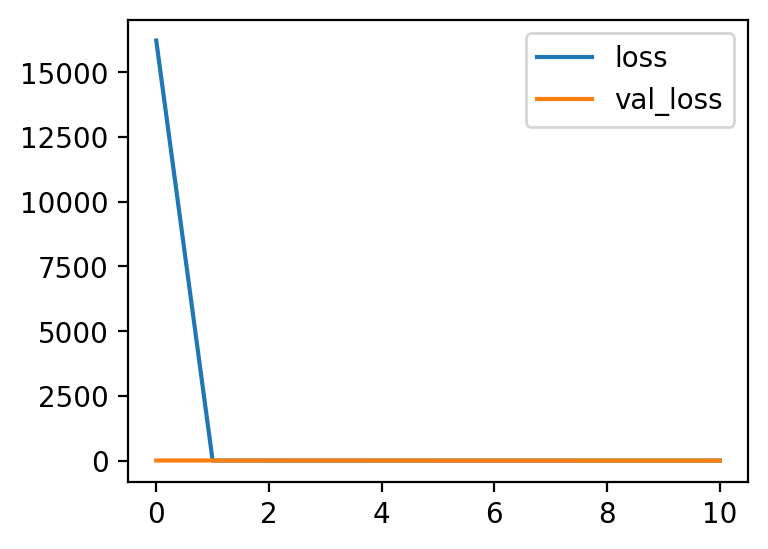

<Figure size 800x600 with 0 Axes>

{'loss': 0.8209131360054016, 'mse': 0.8209131360054016, 'val_loss': 0.9706029891967773, 'val_mse': 0.9706029891967773}
46/46 [==============================] - 3s 72ms/step - loss: 0.8209 - mse: 0.8209 - val_loss: 0.9706 - val_mse: 0.9706
Epoch 12/100
46/46 [==============================] - ETA: 0s - loss: 0.8237 - mse: 0.8237
Epoch 12: val_loss did not improve from 0.97060


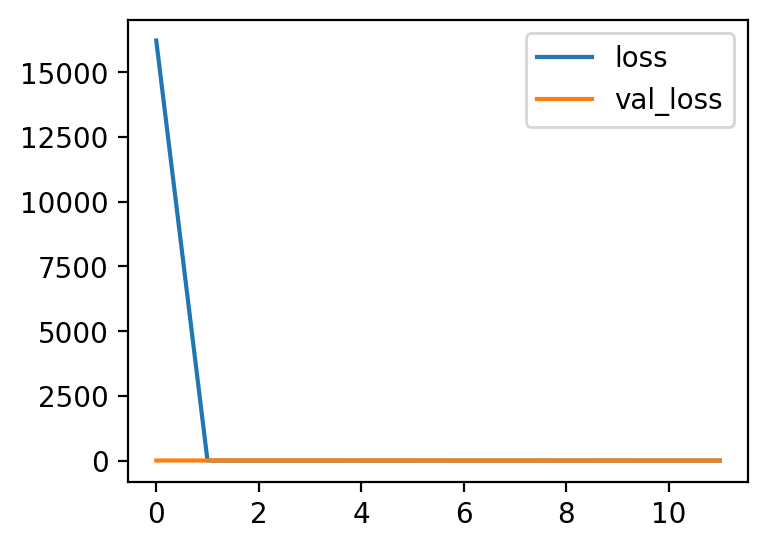

<Figure size 800x600 with 0 Axes>

{'loss': 0.8236976861953735, 'mse': 0.8236976861953735, 'val_loss': 1.0334773063659668, 'val_mse': 1.0334773063659668}
46/46 [==============================] - 1s 30ms/step - loss: 0.8237 - mse: 0.8237 - val_loss: 1.0335 - val_mse: 1.0335
Epoch 13/100
46/46 [==============================] - ETA: 0s - loss: 0.7501 - mse: 0.7501
Epoch 13: val_loss did not improve from 0.97060


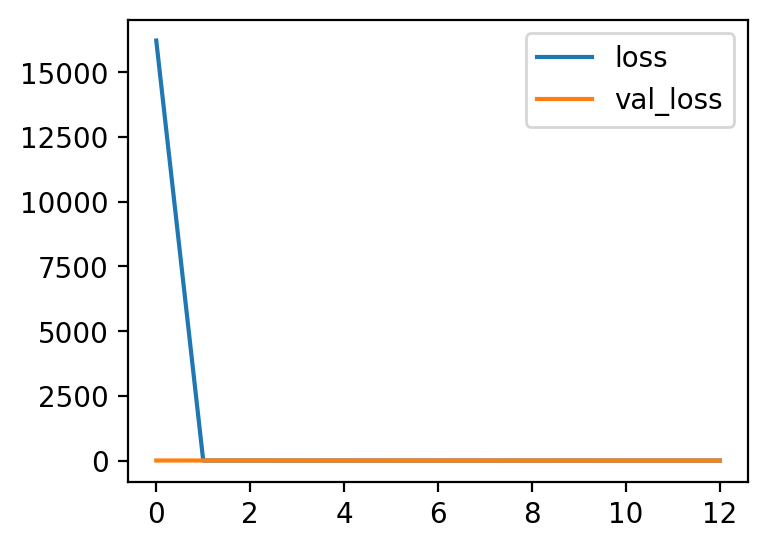

<Figure size 800x600 with 0 Axes>

{'loss': 0.7501309514045715, 'mse': 0.7501309514045715, 'val_loss': 1.0952390432357788, 'val_mse': 1.0952390432357788}
46/46 [==============================] - 1s 27ms/step - loss: 0.7501 - mse: 0.7501 - val_loss: 1.0952 - val_mse: 1.0952
Epoch 14/100
46/46 [==============================] - ETA: 0s - loss: 0.8169 - mse: 0.8169
Epoch 14: val_loss did not improve from 0.97060


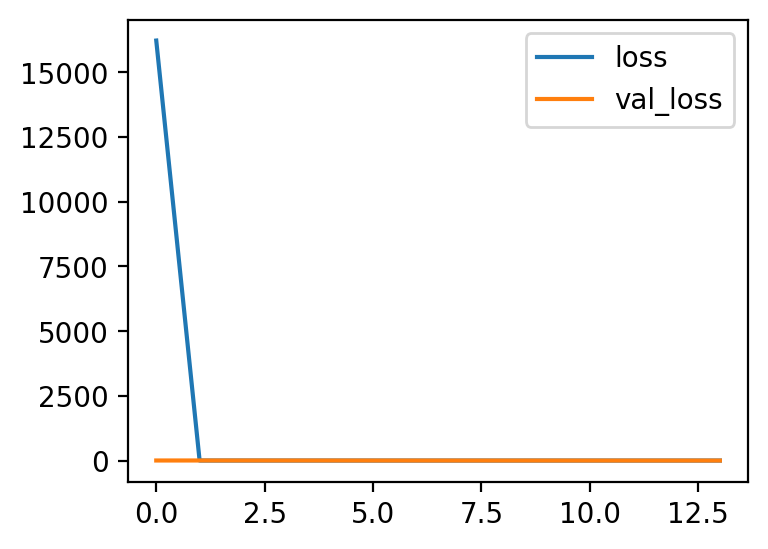

<Figure size 800x600 with 0 Axes>

{'loss': 0.8169355988502502, 'mse': 0.8169355988502502, 'val_loss': 1.031587839126587, 'val_mse': 1.031587839126587}
46/46 [==============================] - 1s 27ms/step - loss: 0.8169 - mse: 0.8169 - val_loss: 1.0316 - val_mse: 1.0316
Epoch 15/100
46/46 [==============================] - ETA: 0s - loss: 0.7378 - mse: 0.7378
Epoch 15: val_loss did not improve from 0.97060


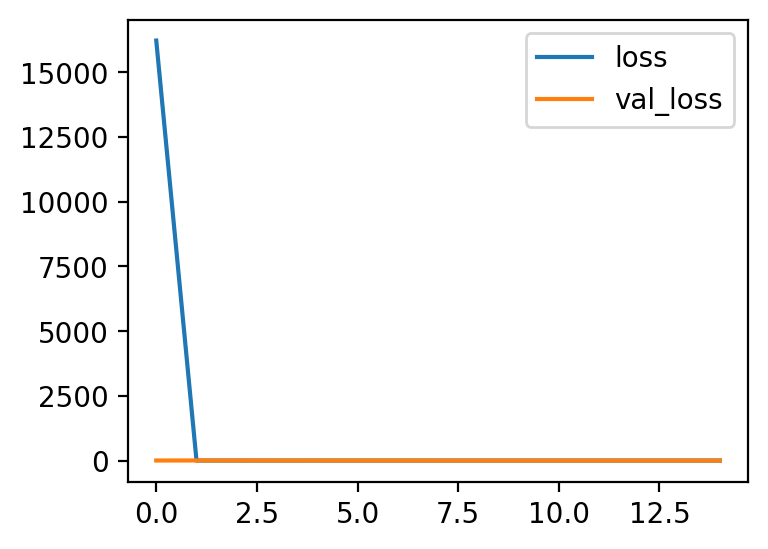

<Figure size 800x600 with 0 Axes>

{'loss': 0.7377501130104065, 'mse': 0.7377501130104065, 'val_loss': 1.021409034729004, 'val_mse': 1.021409034729004}
46/46 [==============================] - 1s 27ms/step - loss: 0.7378 - mse: 0.7378 - val_loss: 1.0214 - val_mse: 1.0214
Epoch 16/100
46/46 [==============================] - ETA: 0s - loss: 0.7594 - mse: 0.7594
Epoch 16: val_loss did not improve from 0.97060


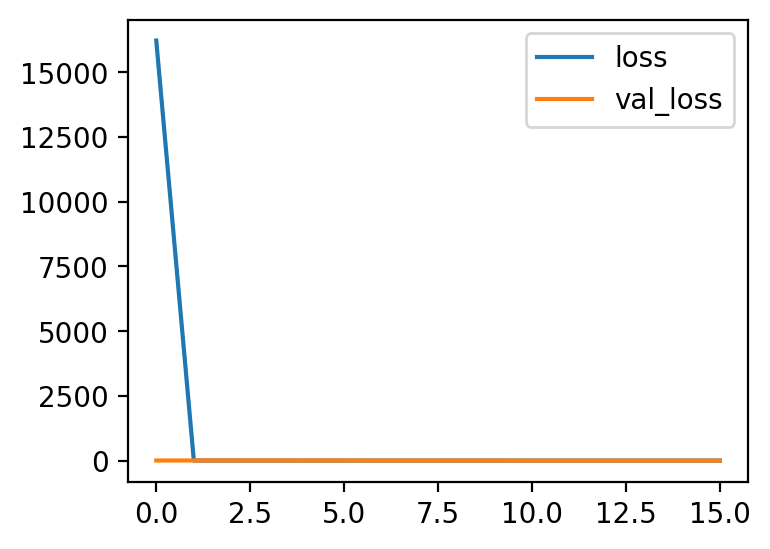

<Figure size 800x600 with 0 Axes>

{'loss': 0.7594031095504761, 'mse': 0.7594031095504761, 'val_loss': 0.9858668446540833, 'val_mse': 0.9858668446540833}
46/46 [==============================] - 1s 27ms/step - loss: 0.7594 - mse: 0.7594 - val_loss: 0.9859 - val_mse: 0.9859
Epoch 17/100
46/46 [==============================] - ETA: 0s - loss: 0.7731 - mse: 0.7731
Epoch 17: val_loss did not improve from 0.97060


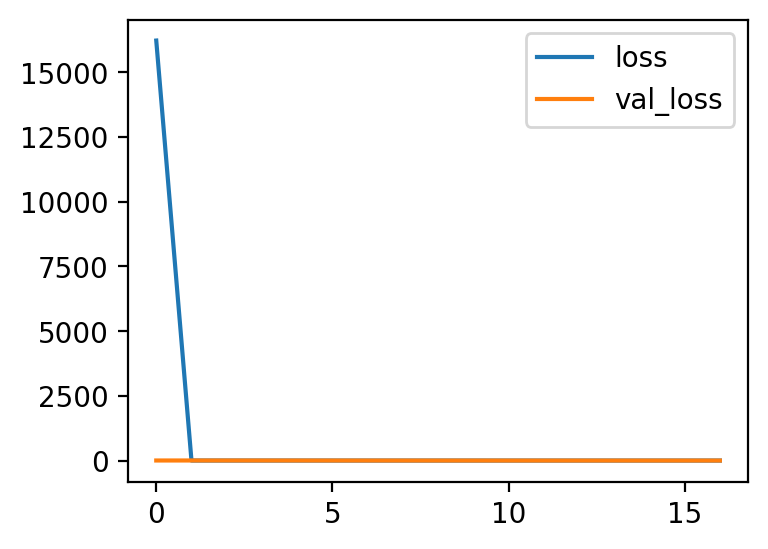

<Figure size 800x600 with 0 Axes>

{'loss': 0.7731075882911682, 'mse': 0.7731075882911682, 'val_loss': 1.3549927473068237, 'val_mse': 1.3549927473068237}
46/46 [==============================] - 1s 27ms/step - loss: 0.7731 - mse: 0.7731 - val_loss: 1.3550 - val_mse: 1.3550
Epoch 18/100
46/46 [==============================] - ETA: 0s - loss: 0.8403 - mse: 0.8403
Epoch 18: val_loss did not improve from 0.97060


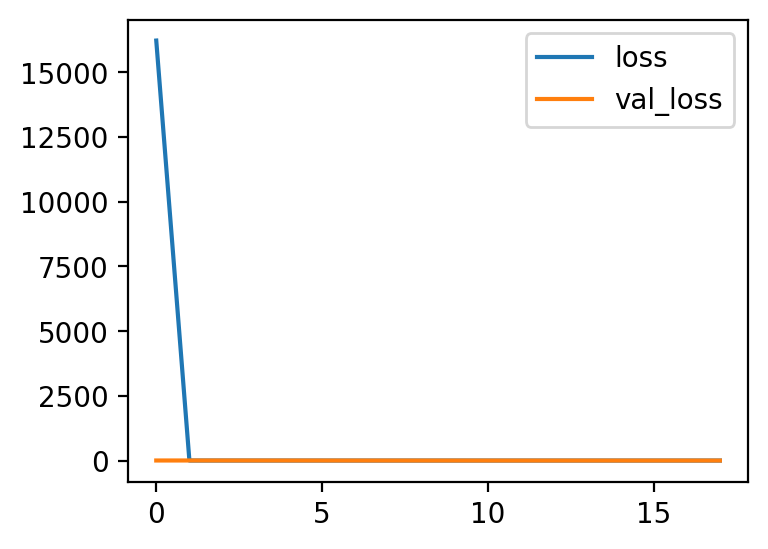

<Figure size 800x600 with 0 Axes>

{'loss': 0.8402877449989319, 'mse': 0.8402877449989319, 'val_loss': 1.211503267288208, 'val_mse': 1.211503267288208}
46/46 [==============================] - 1s 27ms/step - loss: 0.8403 - mse: 0.8403 - val_loss: 1.2115 - val_mse: 1.2115
Epoch 19/100
46/46 [==============================] - ETA: 0s - loss: 0.7933 - mse: 0.7933
Epoch 19: val_loss did not improve from 0.97060


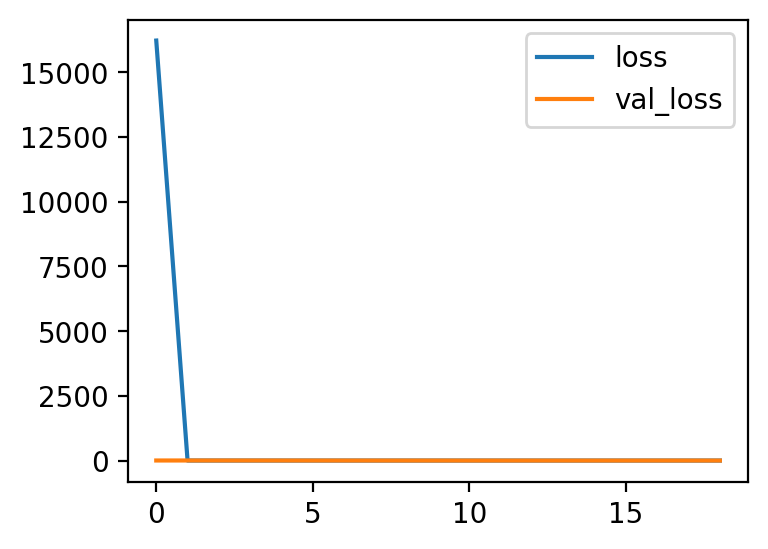

<Figure size 800x600 with 0 Axes>

{'loss': 0.793323814868927, 'mse': 0.793323814868927, 'val_loss': 1.0621652603149414, 'val_mse': 1.0621652603149414}
46/46 [==============================] - 1s 27ms/step - loss: 0.7933 - mse: 0.7933 - val_loss: 1.0622 - val_mse: 1.0622
Epoch 20/100
46/46 [==============================] - ETA: 0s - loss: 0.7820 - mse: 0.7820
Epoch 20: val_loss did not improve from 0.97060


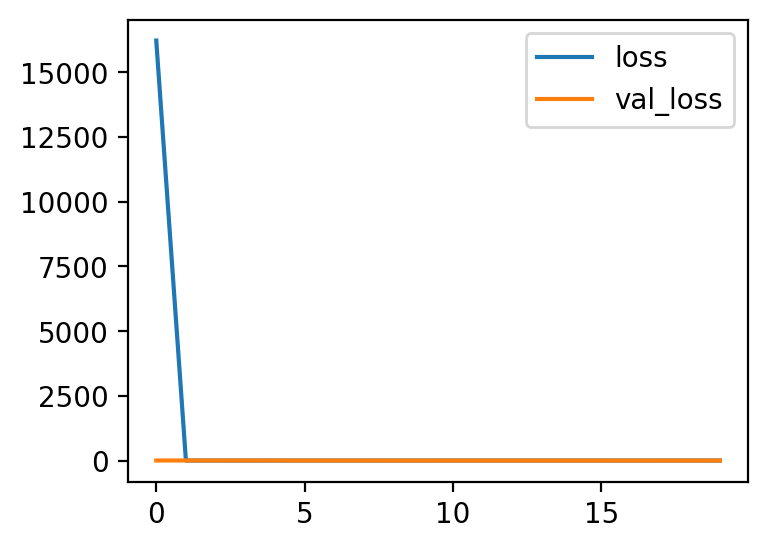

<Figure size 800x600 with 0 Axes>

{'loss': 0.7819957733154297, 'mse': 0.7819957733154297, 'val_loss': 1.7118041515350342, 'val_mse': 1.7118041515350342}
46/46 [==============================] - 1s 27ms/step - loss: 0.7820 - mse: 0.7820 - val_loss: 1.7118 - val_mse: 1.7118
Epoch 21/100
46/46 [==============================] - ETA: 0s - loss: 0.7930 - mse: 0.7930
Epoch 21: val_loss did not improve from 0.97060


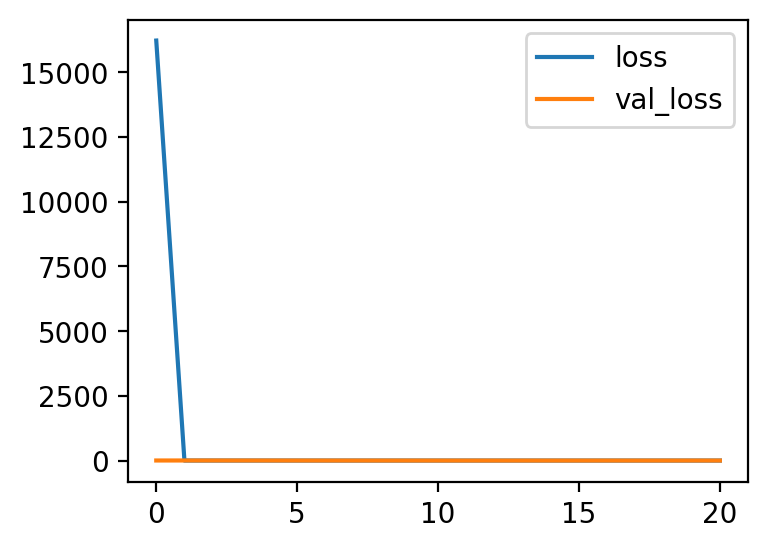

<Figure size 800x600 with 0 Axes>

{'loss': 0.7929880619049072, 'mse': 0.7929880619049072, 'val_loss': 1.3804367780685425, 'val_mse': 1.3804367780685425}
46/46 [==============================] - 1s 27ms/step - loss: 0.7930 - mse: 0.7930 - val_loss: 1.3804 - val_mse: 1.3804
Epoch 22/100
46/46 [==============================] - ETA: 0s - loss: 0.7656 - mse: 0.7656
Epoch 22: val_loss did not improve from 0.97060


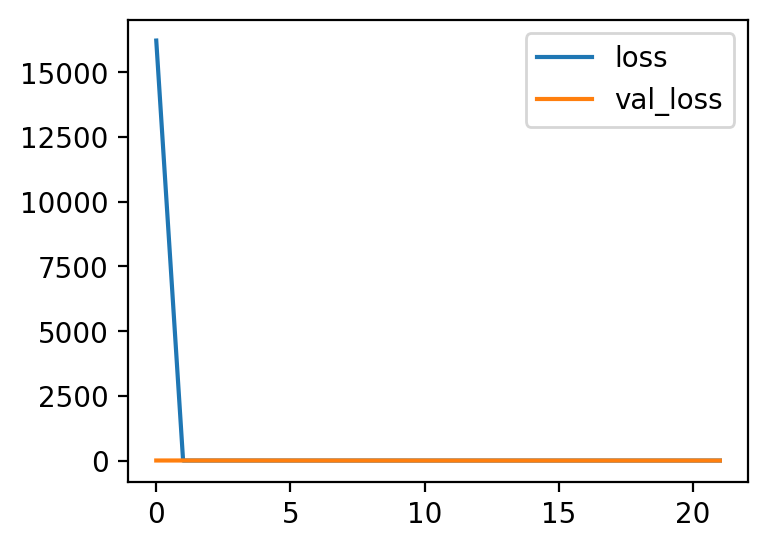

<Figure size 800x600 with 0 Axes>

{'loss': 0.7656050324440002, 'mse': 0.7656050324440002, 'val_loss': 1.1422897577285767, 'val_mse': 1.1422897577285767}
46/46 [==============================] - 1s 27ms/step - loss: 0.7656 - mse: 0.7656 - val_loss: 1.1423 - val_mse: 1.1423
Epoch 23/100
46/46 [==============================] - ETA: 0s - loss: 0.7881 - mse: 0.7881
Epoch 23: val_loss did not improve from 0.97060


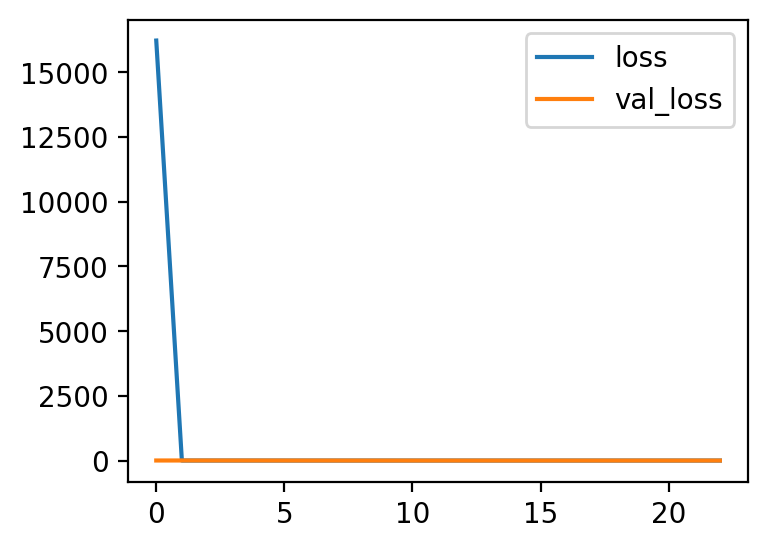

<Figure size 800x600 with 0 Axes>

{'loss': 0.7881469130516052, 'mse': 0.7881469130516052, 'val_loss': 1.4718345403671265, 'val_mse': 1.4718345403671265}
46/46 [==============================] - 1s 27ms/step - loss: 0.7881 - mse: 0.7881 - val_loss: 1.4718 - val_mse: 1.4718
Epoch 24/100
45/46 [============================>.] - ETA: 0s - loss: 0.8048 - mse: 0.8048
Epoch 24: val_loss did not improve from 0.97060


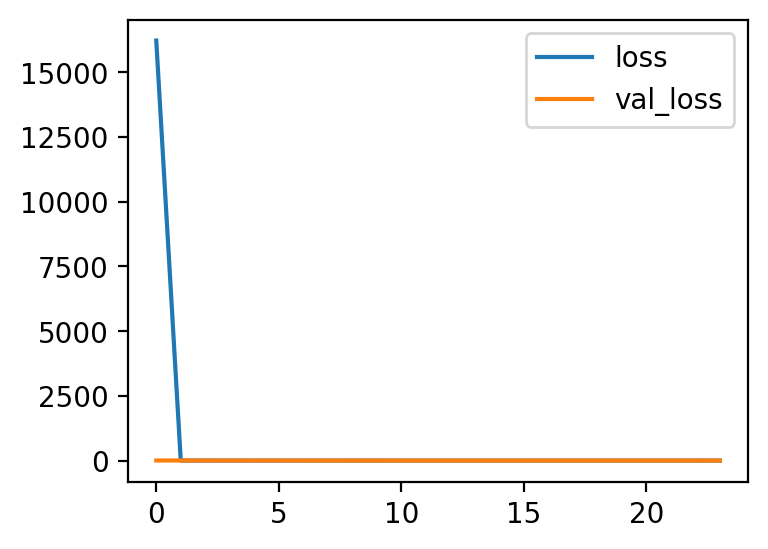

<Figure size 800x600 with 0 Axes>

{'loss': 0.8039291501045227, 'mse': 0.8039291501045227, 'val_loss': 1.066292643547058, 'val_mse': 1.066292643547058}
46/46 [==============================] - 1s 27ms/step - loss: 0.8039 - mse: 0.8039 - val_loss: 1.0663 - val_mse: 1.0663
Epoch 25/100
46/46 [==============================] - ETA: 0s - loss: 0.7962 - mse: 0.7962
Epoch 25: val_loss did not improve from 0.97060


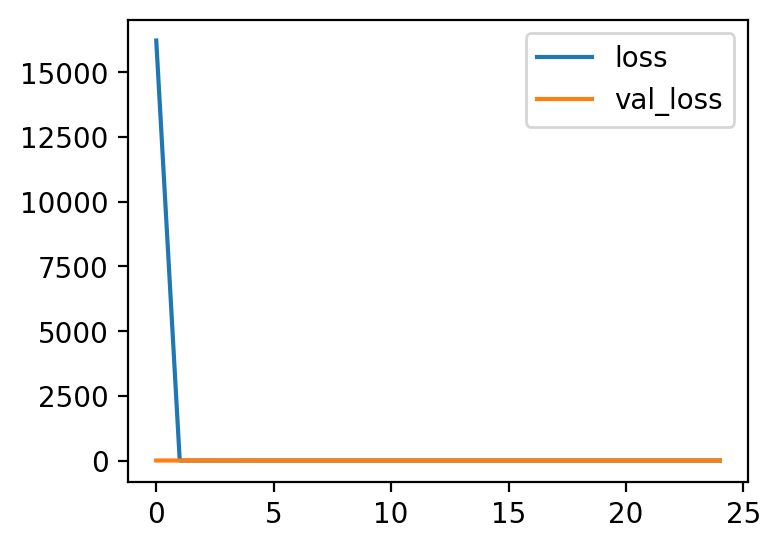

<Figure size 800x600 with 0 Axes>

{'loss': 0.796154797077179, 'mse': 0.796154797077179, 'val_loss': 1.346382737159729, 'val_mse': 1.346382737159729}
46/46 [==============================] - 1s 27ms/step - loss: 0.7962 - mse: 0.7962 - val_loss: 1.3464 - val_mse: 1.3464
Epoch 26/100
46/46 [==============================] - ETA: 0s - loss: 0.8059 - mse: 0.8059
Epoch 26: val_loss did not improve from 0.97060


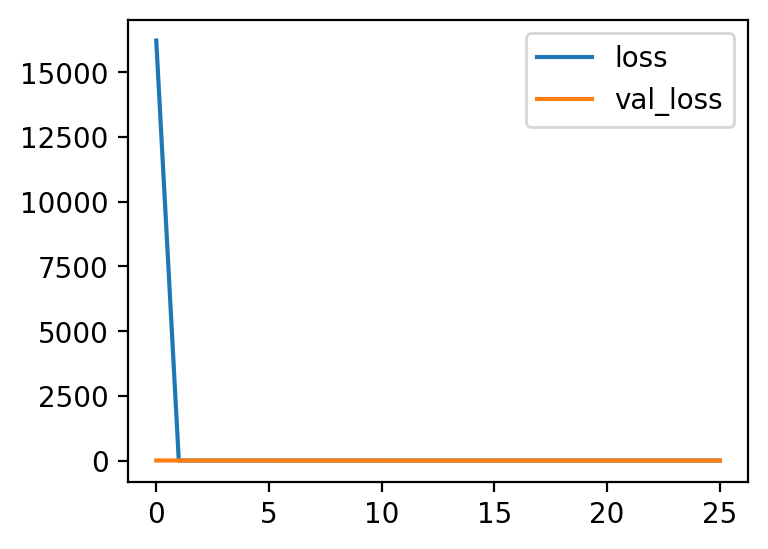

<Figure size 800x600 with 0 Axes>

{'loss': 0.805896520614624, 'mse': 0.805896520614624, 'val_loss': 1.1183067560195923, 'val_mse': 1.1183067560195923}
46/46 [==============================] - 1s 27ms/step - loss: 0.8059 - mse: 0.8059 - val_loss: 1.1183 - val_mse: 1.1183
Epoch 27/100
46/46 [==============================] - ETA: 0s - loss: 0.7955 - mse: 0.7955
Epoch 27: val_loss did not improve from 0.97060


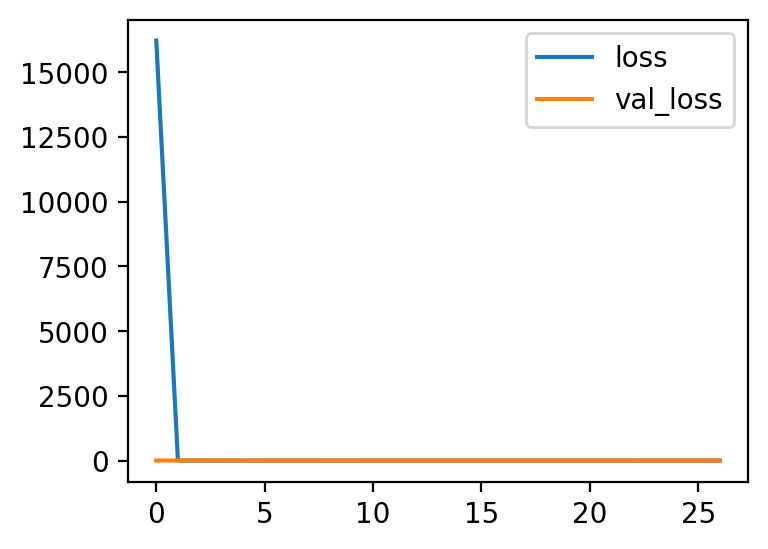

<Figure size 800x600 with 0 Axes>

{'loss': 0.7954922914505005, 'mse': 0.7954922914505005, 'val_loss': 1.0885766744613647, 'val_mse': 1.0885766744613647}
46/46 [==============================] - 1s 27ms/step - loss: 0.7955 - mse: 0.7955 - val_loss: 1.0886 - val_mse: 1.0886
Epoch 28/100
45/46 [============================>.] - ETA: 0s - loss: 0.8147 - mse: 0.8147
Epoch 28: val_loss did not improve from 0.97060


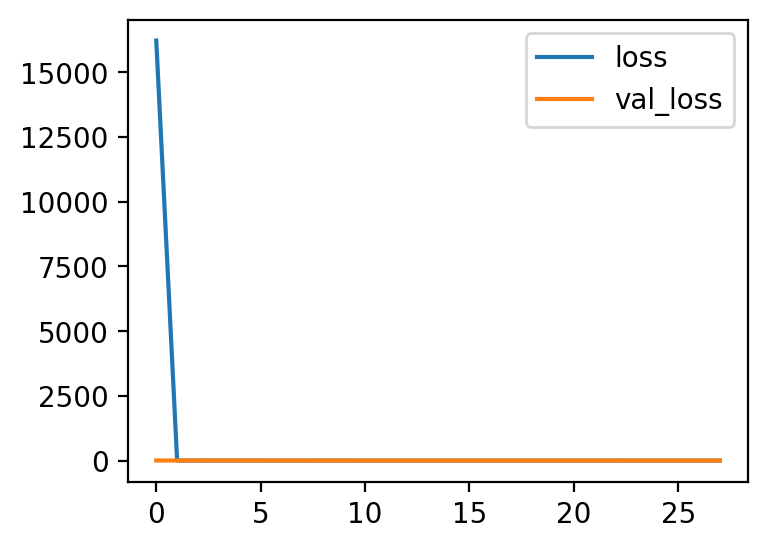

<Figure size 800x600 with 0 Axes>

{'loss': 0.8138556480407715, 'mse': 0.8138556480407715, 'val_loss': 1.234397053718567, 'val_mse': 1.234397053718567}
46/46 [==============================] - 1s 27ms/step - loss: 0.8139 - mse: 0.8139 - val_loss: 1.2344 - val_mse: 1.2344
Epoch 29/100
46/46 [==============================] - ETA: 0s - loss: 0.7511 - mse: 0.7511
Epoch 29: val_loss did not improve from 0.97060


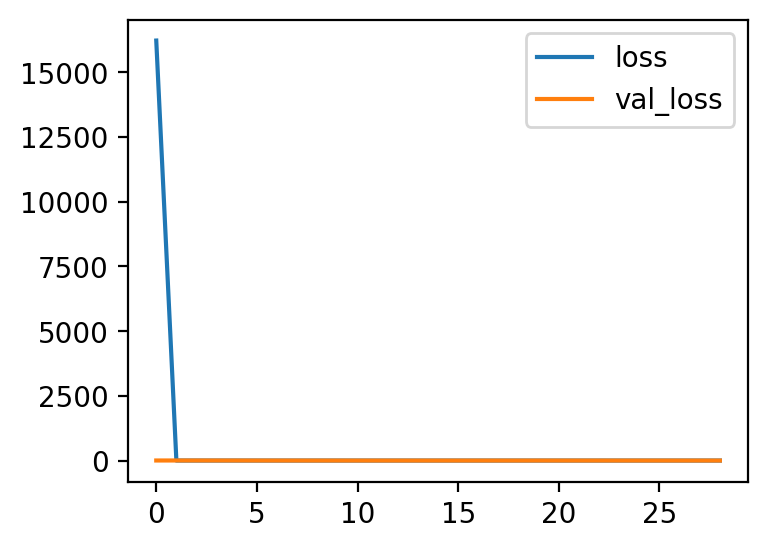

<Figure size 800x600 with 0 Axes>

{'loss': 0.7511131763458252, 'mse': 0.7511131763458252, 'val_loss': 1.203047513961792, 'val_mse': 1.203047513961792}
46/46 [==============================] - 1s 27ms/step - loss: 0.7511 - mse: 0.7511 - val_loss: 1.2030 - val_mse: 1.2030
Epoch 30/100
46/46 [==============================] - ETA: 0s - loss: 0.8049 - mse: 0.8049
Epoch 30: val_loss did not improve from 0.97060


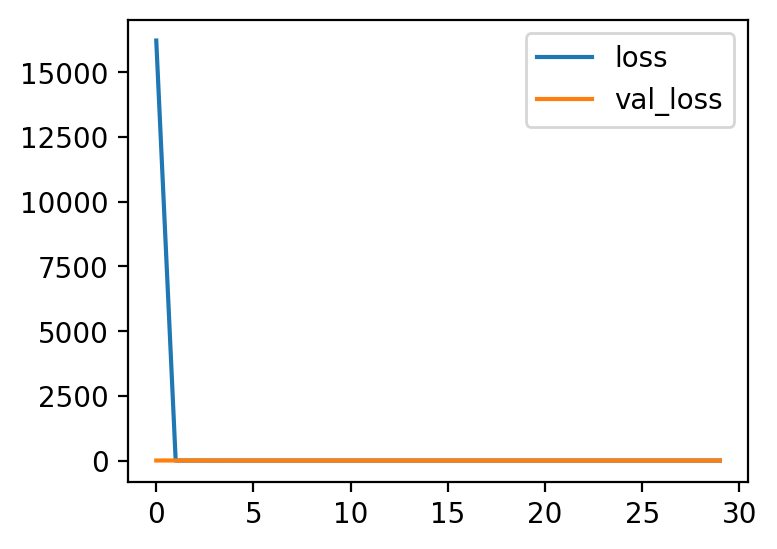

<Figure size 800x600 with 0 Axes>

{'loss': 0.8049048781394958, 'mse': 0.8049048781394958, 'val_loss': 1.3202588558197021, 'val_mse': 1.3202588558197021}
46/46 [==============================] - 1s 27ms/step - loss: 0.8049 - mse: 0.8049 - val_loss: 1.3203 - val_mse: 1.3203
Epoch 31/100
46/46 [==============================] - ETA: 0s - loss: 0.7636 - mse: 0.7636
Epoch 31: val_loss did not improve from 0.97060


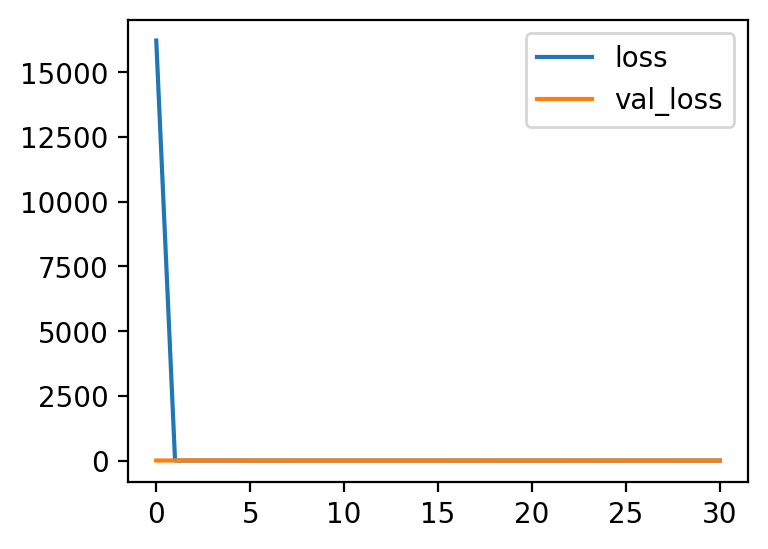

<Figure size 800x600 with 0 Axes>

{'loss': 0.763573944568634, 'mse': 0.763573944568634, 'val_loss': 1.1553223133087158, 'val_mse': 1.1553223133087158}
46/46 [==============================] - 1s 27ms/step - loss: 0.7636 - mse: 0.7636 - val_loss: 1.1553 - val_mse: 1.1553
Epoch 32/100
46/46 [==============================] - ETA: 0s - loss: 0.7849 - mse: 0.7849
Epoch 32: val_loss did not improve from 0.97060


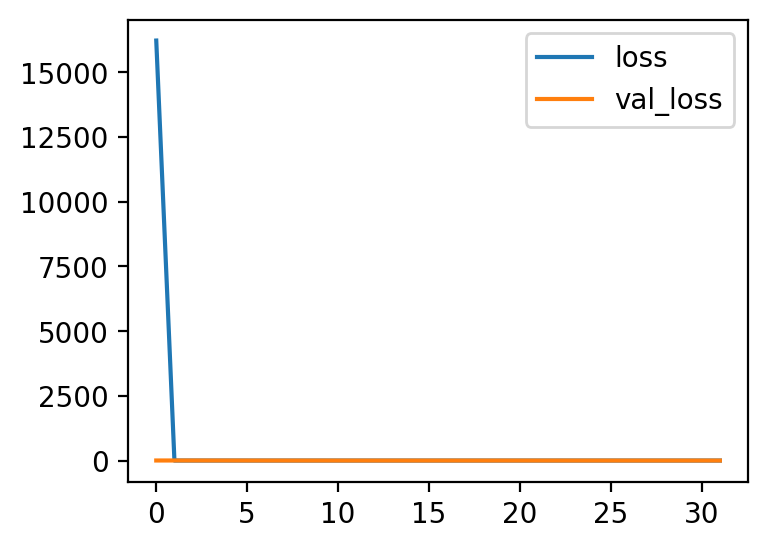

<Figure size 800x600 with 0 Axes>

{'loss': 0.7849045991897583, 'mse': 0.7849045991897583, 'val_loss': 1.2482738494873047, 'val_mse': 1.2482738494873047}
46/46 [==============================] - 1s 27ms/step - loss: 0.7849 - mse: 0.7849 - val_loss: 1.2483 - val_mse: 1.2483
Epoch 33/100
46/46 [==============================] - ETA: 0s - loss: 0.7969 - mse: 0.7969
Epoch 33: val_loss did not improve from 0.97060


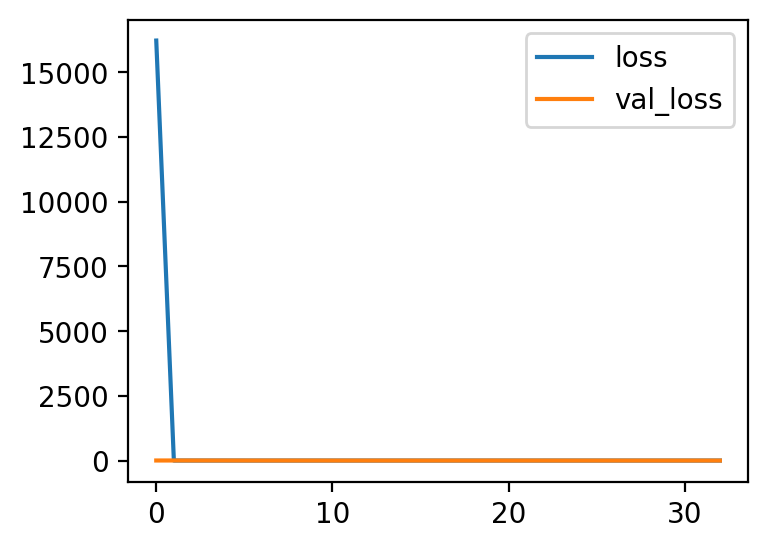

<Figure size 800x600 with 0 Axes>

{'loss': 0.7968651652336121, 'mse': 0.7968651652336121, 'val_loss': 1.0507608652114868, 'val_mse': 1.0507608652114868}
46/46 [==============================] - 1s 27ms/step - loss: 0.7969 - mse: 0.7969 - val_loss: 1.0508 - val_mse: 1.0508
Epoch 34/100
46/46 [==============================] - ETA: 0s - loss: 0.7947 - mse: 0.7947
Epoch 34: val_loss did not improve from 0.97060


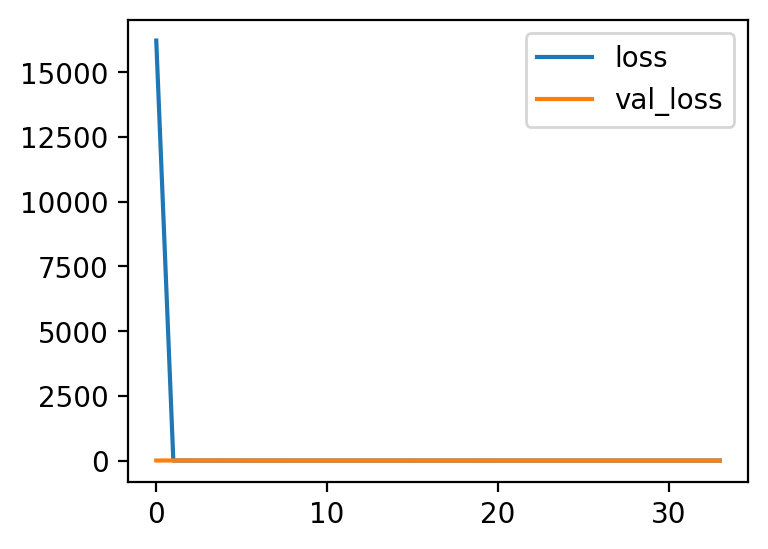

<Figure size 800x600 with 0 Axes>

{'loss': 0.7947196364402771, 'mse': 0.7947196364402771, 'val_loss': 1.1622052192687988, 'val_mse': 1.1622052192687988}
46/46 [==============================] - 1s 27ms/step - loss: 0.7947 - mse: 0.7947 - val_loss: 1.1622 - val_mse: 1.1622
Epoch 35/100
46/46 [==============================] - ETA: 0s - loss: 0.8976 - mse: 0.8976
Epoch 35: val_loss did not improve from 0.97060


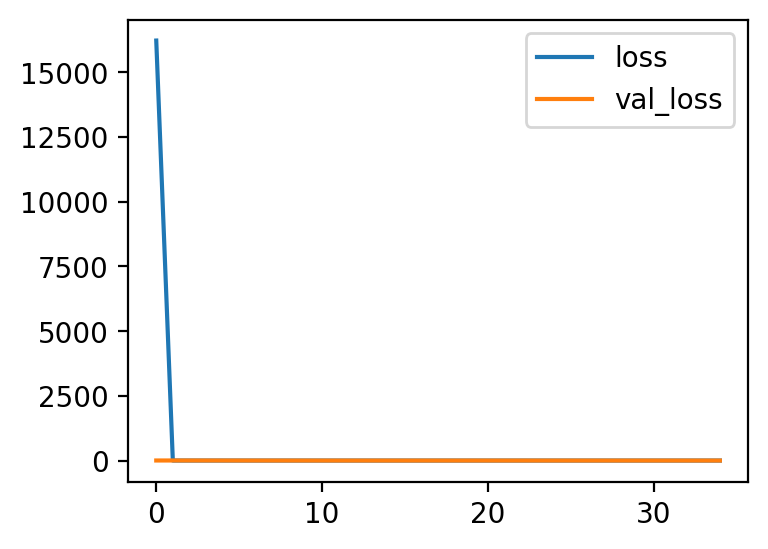

<Figure size 800x600 with 0 Axes>

{'loss': 0.8975920677185059, 'mse': 0.8975920677185059, 'val_loss': 1.334841012954712, 'val_mse': 1.334841012954712}
46/46 [==============================] - 1s 27ms/step - loss: 0.8976 - mse: 0.8976 - val_loss: 1.3348 - val_mse: 1.3348
Epoch 36/100
46/46 [==============================] - ETA: 0s - loss: 0.7529 - mse: 0.7529
Epoch 36: val_loss did not improve from 0.97060


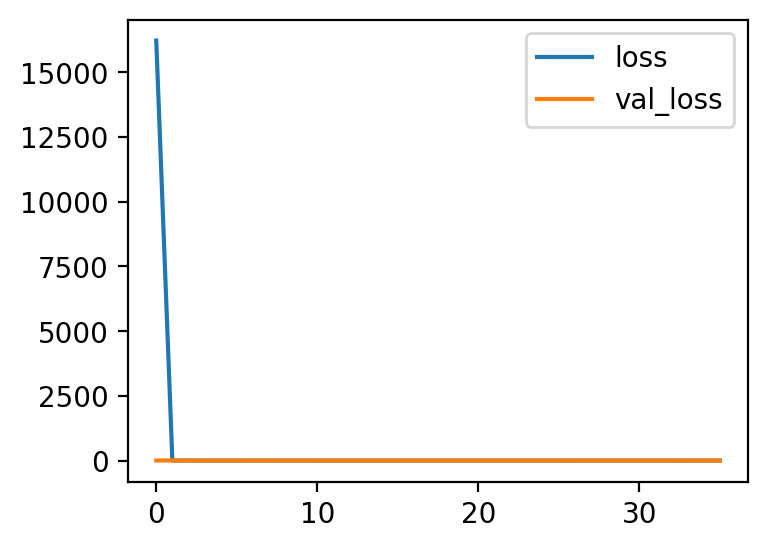

<Figure size 800x600 with 0 Axes>

{'loss': 0.7529397010803223, 'mse': 0.7529397010803223, 'val_loss': 1.178093433380127, 'val_mse': 1.178093433380127}
46/46 [==============================] - 1s 27ms/step - loss: 0.7529 - mse: 0.7529 - val_loss: 1.1781 - val_mse: 1.1781
Epoch 37/100
46/46 [==============================] - ETA: 0s - loss: 0.8302 - mse: 0.8302
Epoch 37: val_loss did not improve from 0.97060


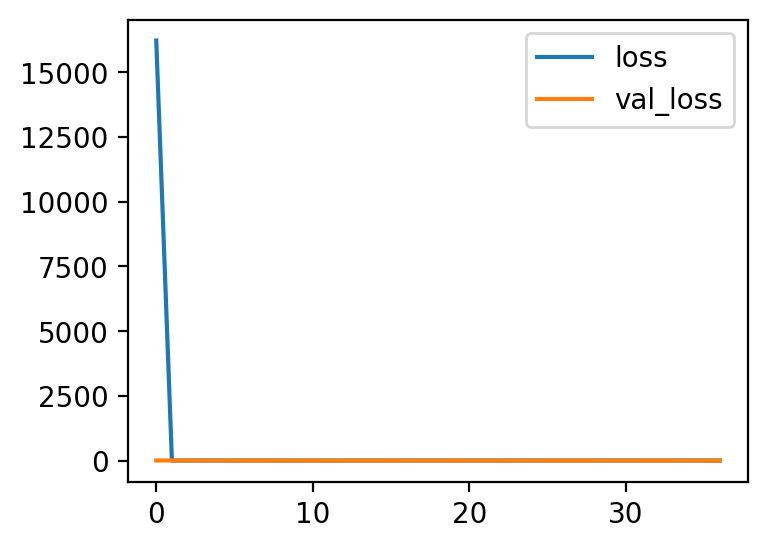

<Figure size 800x600 with 0 Axes>

{'loss': 0.8302361965179443, 'mse': 0.8302361965179443, 'val_loss': 1.1221270561218262, 'val_mse': 1.1221270561218262}
46/46 [==============================] - 1s 27ms/step - loss: 0.8302 - mse: 0.8302 - val_loss: 1.1221 - val_mse: 1.1221
Epoch 38/100
46/46 [==============================] - ETA: 0s - loss: 0.7954 - mse: 0.7954
Epoch 38: val_loss did not improve from 0.97060


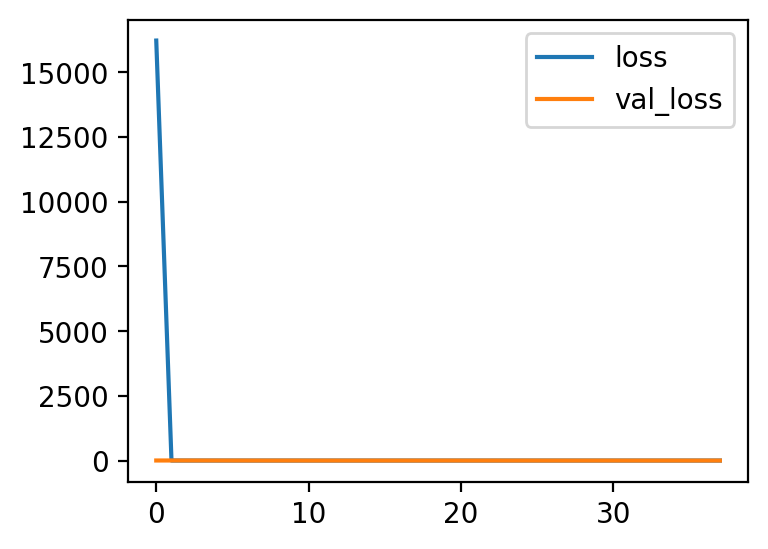

<Figure size 800x600 with 0 Axes>

{'loss': 0.7953506708145142, 'mse': 0.7953506708145142, 'val_loss': 1.44227135181427, 'val_mse': 1.44227135181427}
46/46 [==============================] - 1s 27ms/step - loss: 0.7954 - mse: 0.7954 - val_loss: 1.4423 - val_mse: 1.4423
Epoch 39/100
46/46 [==============================] - ETA: 0s - loss: 0.7375 - mse: 0.7375
Epoch 39: val_loss did not improve from 0.97060


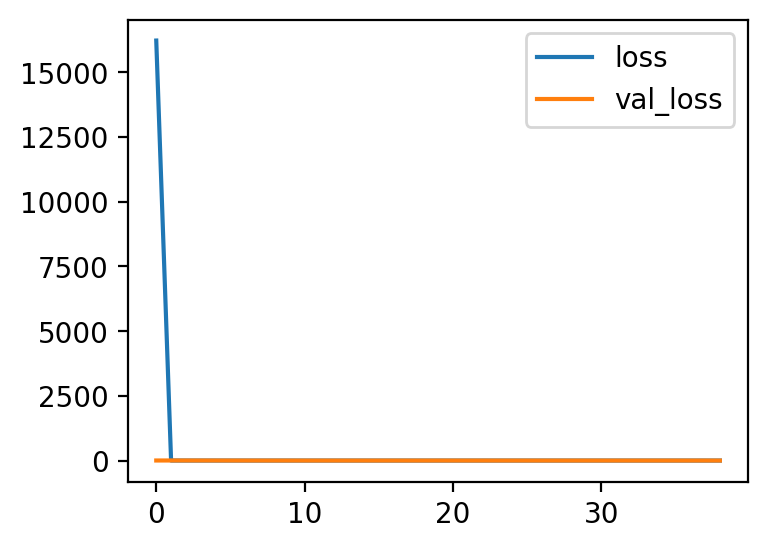

<Figure size 800x600 with 0 Axes>

{'loss': 0.7375299334526062, 'mse': 0.7375299334526062, 'val_loss': 1.1298226118087769, 'val_mse': 1.1298226118087769}
46/46 [==============================] - 1s 27ms/step - loss: 0.7375 - mse: 0.7375 - val_loss: 1.1298 - val_mse: 1.1298
Epoch 40/100
46/46 [==============================] - ETA: 0s - loss: 0.8099 - mse: 0.8099
Epoch 40: val_loss did not improve from 0.97060


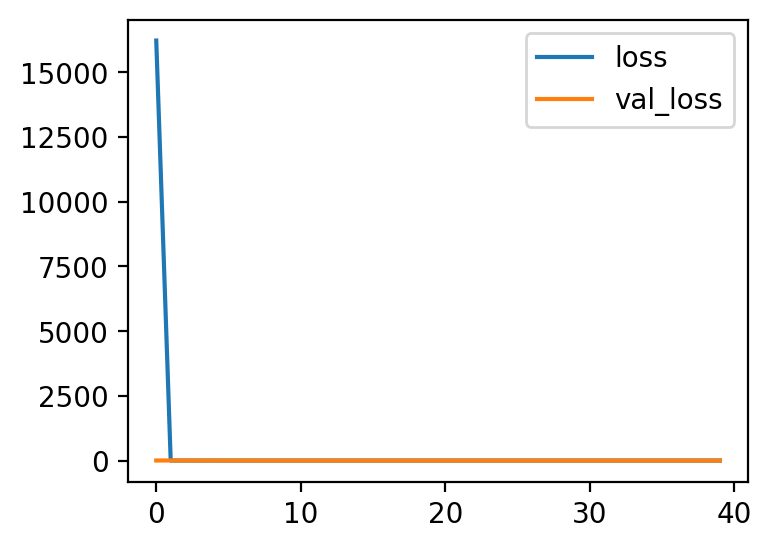

<Figure size 800x600 with 0 Axes>

{'loss': 0.8099329471588135, 'mse': 0.8099329471588135, 'val_loss': 1.3365986347198486, 'val_mse': 1.3365986347198486}
46/46 [==============================] - 1s 27ms/step - loss: 0.8099 - mse: 0.8099 - val_loss: 1.3366 - val_mse: 1.3366
Epoch 41/100
46/46 [==============================] - ETA: 0s - loss: 0.7813 - mse: 0.7813
Epoch 41: val_loss did not improve from 0.97060


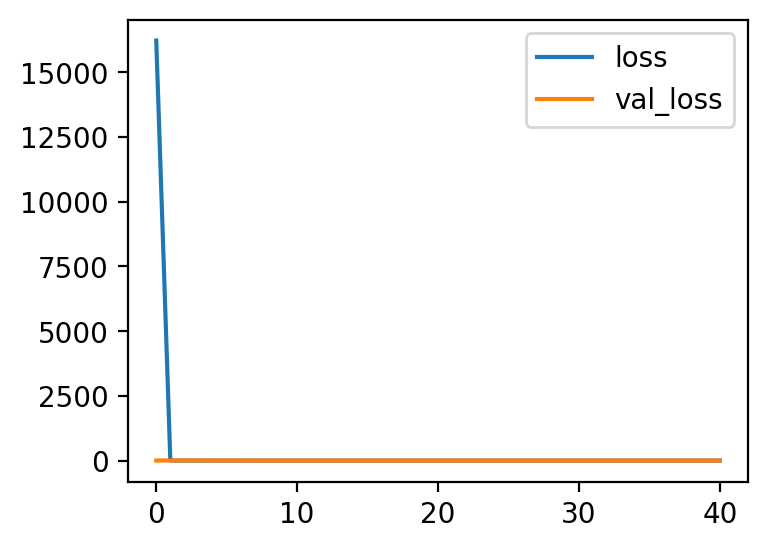

<Figure size 800x600 with 0 Axes>

{'loss': 0.7812880277633667, 'mse': 0.7812880277633667, 'val_loss': 1.1275995969772339, 'val_mse': 1.1275995969772339}
46/46 [==============================] - 1s 27ms/step - loss: 0.7813 - mse: 0.7813 - val_loss: 1.1276 - val_mse: 1.1276
Epoch 42/100
46/46 [==============================] - ETA: 0s - loss: 0.8399 - mse: 0.8399
Epoch 42: val_loss did not improve from 0.97060


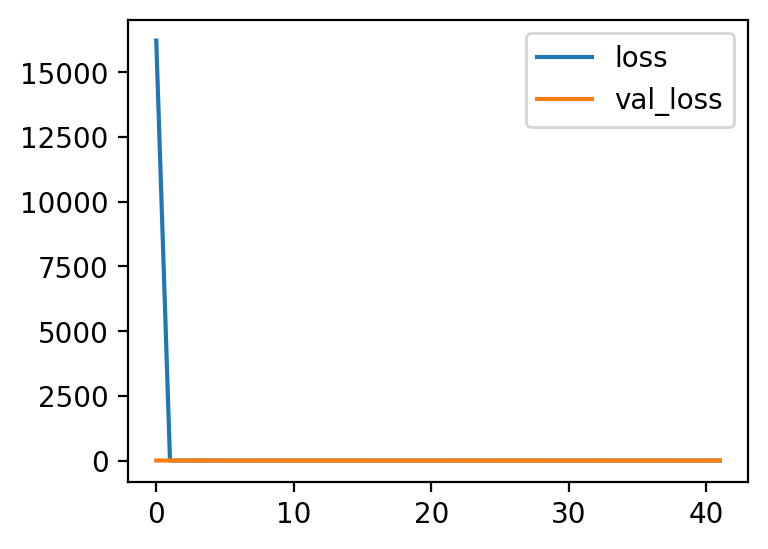

<Figure size 800x600 with 0 Axes>

{'loss': 0.8398846983909607, 'mse': 0.8398846983909607, 'val_loss': 1.2801263332366943, 'val_mse': 1.2801263332366943}
46/46 [==============================] - 1s 27ms/step - loss: 0.8399 - mse: 0.8399 - val_loss: 1.2801 - val_mse: 1.2801
Epoch 43/100
46/46 [==============================] - ETA: 0s - loss: 0.7824 - mse: 0.7824
Epoch 43: val_loss did not improve from 0.97060


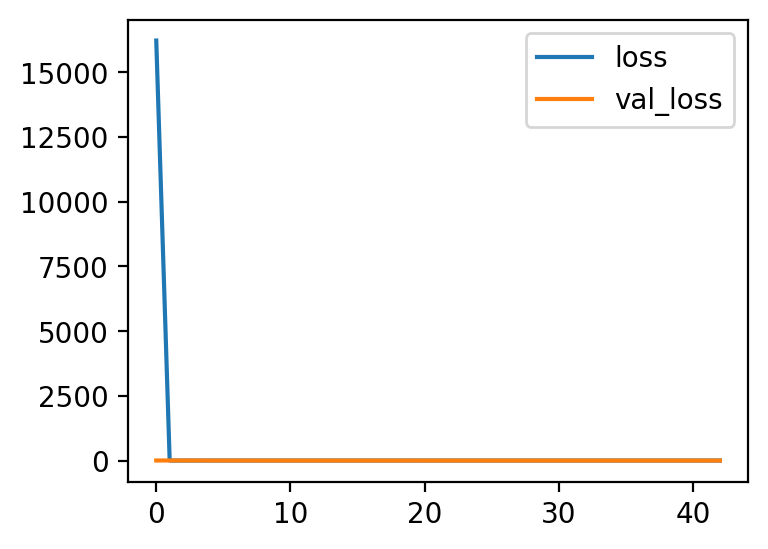

<Figure size 800x600 with 0 Axes>

{'loss': 0.7823726534843445, 'mse': 0.7823726534843445, 'val_loss': 1.617208480834961, 'val_mse': 1.617208480834961}
46/46 [==============================] - 1s 27ms/step - loss: 0.7824 - mse: 0.7824 - val_loss: 1.6172 - val_mse: 1.6172
Epoch 44/100
46/46 [==============================] - ETA: 0s - loss: 0.8274 - mse: 0.8274
Epoch 44: val_loss did not improve from 0.97060


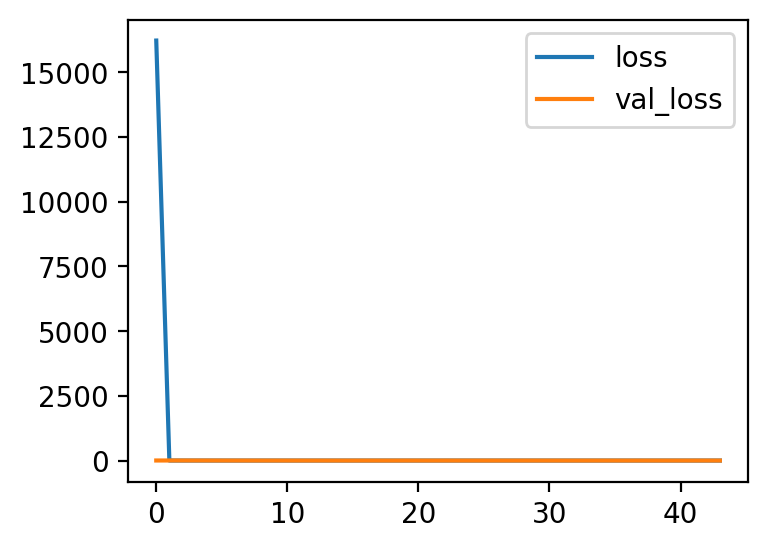

<Figure size 800x600 with 0 Axes>

{'loss': 0.8274146914482117, 'mse': 0.8274146914482117, 'val_loss': 1.2562243938446045, 'val_mse': 1.2562243938446045}
46/46 [==============================] - 1s 27ms/step - loss: 0.8274 - mse: 0.8274 - val_loss: 1.2562 - val_mse: 1.2562
Epoch 45/100
46/46 [==============================] - ETA: 0s - loss: 0.7600 - mse: 0.7600
Epoch 45: val_loss did not improve from 0.97060


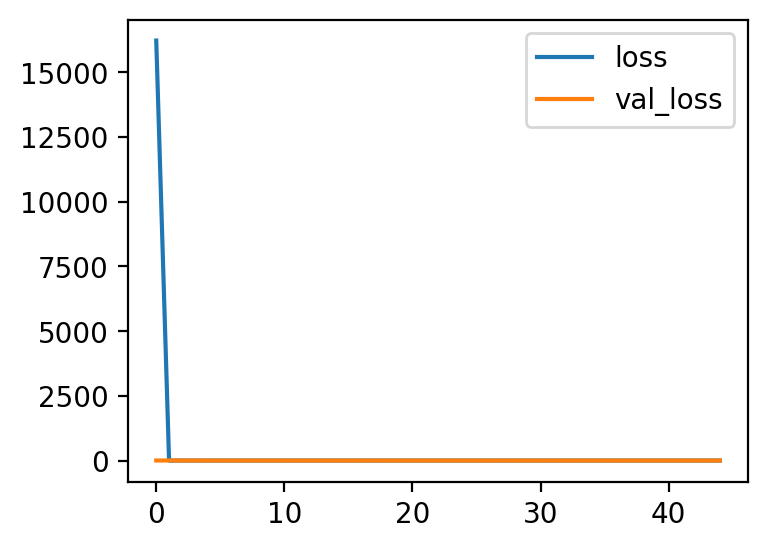

<Figure size 800x600 with 0 Axes>

{'loss': 0.760013222694397, 'mse': 0.760013222694397, 'val_loss': 1.036272644996643, 'val_mse': 1.036272644996643}
46/46 [==============================] - 1s 27ms/step - loss: 0.7600 - mse: 0.7600 - val_loss: 1.0363 - val_mse: 1.0363
Epoch 46/100
46/46 [==============================] - ETA: 0s - loss: 0.7648 - mse: 0.7648
Epoch 46: val_loss did not improve from 0.97060


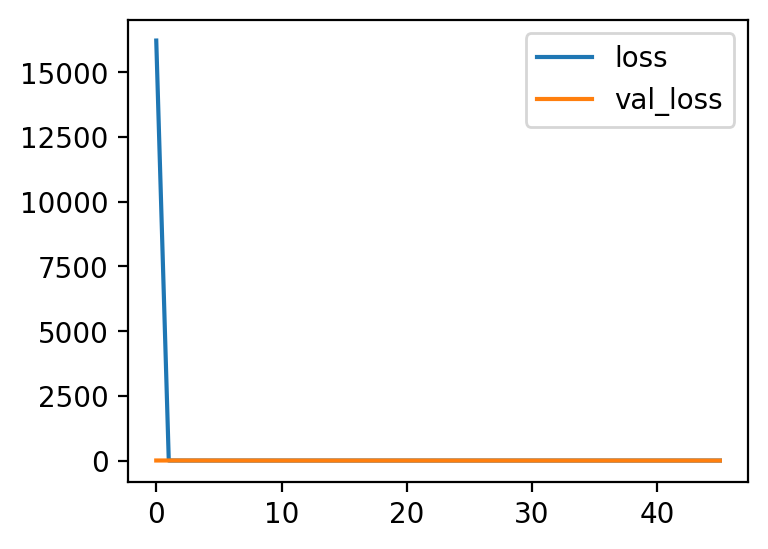

<Figure size 800x600 with 0 Axes>

{'loss': 0.7648166418075562, 'mse': 0.7648166418075562, 'val_loss': 1.0387780666351318, 'val_mse': 1.0387780666351318}
46/46 [==============================] - 1s 27ms/step - loss: 0.7648 - mse: 0.7648 - val_loss: 1.0388 - val_mse: 1.0388
Epoch 47/100
46/46 [==============================] - ETA: 0s - loss: 0.7500 - mse: 0.7500
Epoch 47: val_loss did not improve from 0.97060


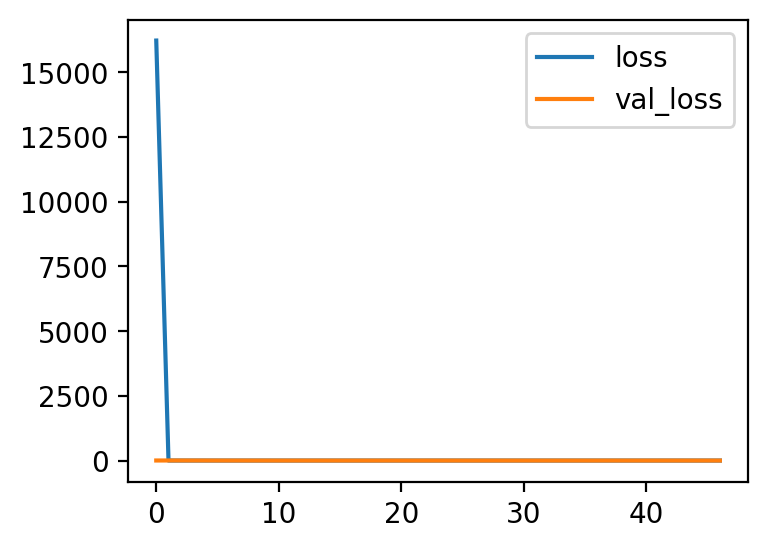

<Figure size 800x600 with 0 Axes>

{'loss': 0.7499772906303406, 'mse': 0.7499772906303406, 'val_loss': 1.0926172733306885, 'val_mse': 1.0926172733306885}
46/46 [==============================] - 1s 27ms/step - loss: 0.7500 - mse: 0.7500 - val_loss: 1.0926 - val_mse: 1.0926
Epoch 48/100
46/46 [==============================] - ETA: 0s - loss: 0.7362 - mse: 0.7362
Epoch 48: val_loss did not improve from 0.97060


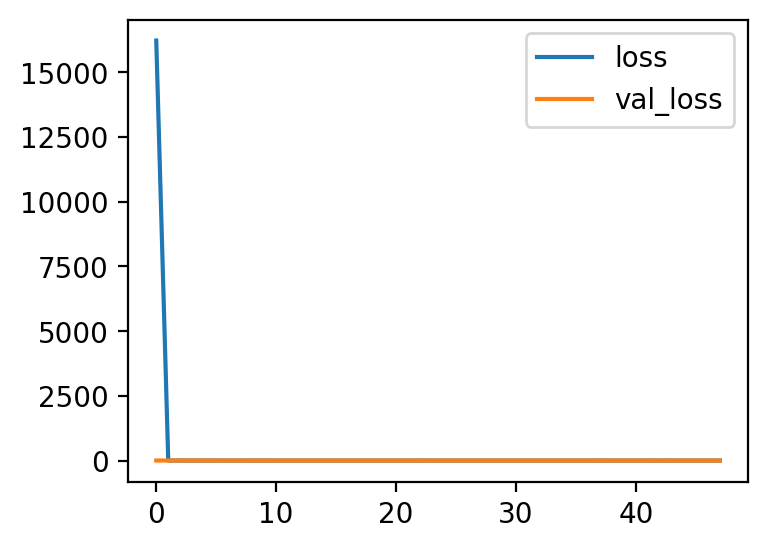

<Figure size 800x600 with 0 Axes>

{'loss': 0.7361709475517273, 'mse': 0.7361709475517273, 'val_loss': 1.0334339141845703, 'val_mse': 1.0334339141845703}
46/46 [==============================] - 1s 27ms/step - loss: 0.7362 - mse: 0.7362 - val_loss: 1.0334 - val_mse: 1.0334
Epoch 49/100
46/46 [==============================] - ETA: 0s - loss: 0.8114 - mse: 0.8114
Epoch 49: val_loss did not improve from 0.97060


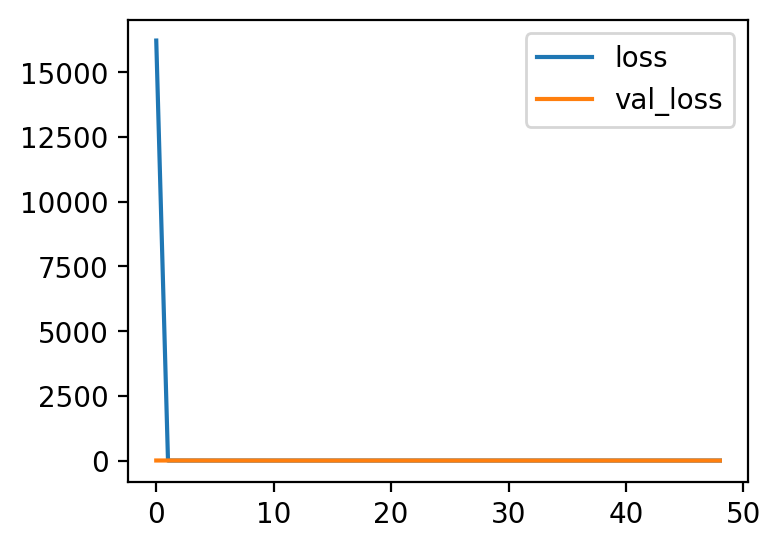

<Figure size 800x600 with 0 Axes>

{'loss': 0.8114124536514282, 'mse': 0.8114124536514282, 'val_loss': 1.0673993825912476, 'val_mse': 1.0673993825912476}
46/46 [==============================] - 1s 27ms/step - loss: 0.8114 - mse: 0.8114 - val_loss: 1.0674 - val_mse: 1.0674
Epoch 50/100
46/46 [==============================] - ETA: 0s - loss: 0.7791 - mse: 0.7791
Epoch 50: val_loss did not improve from 0.97060


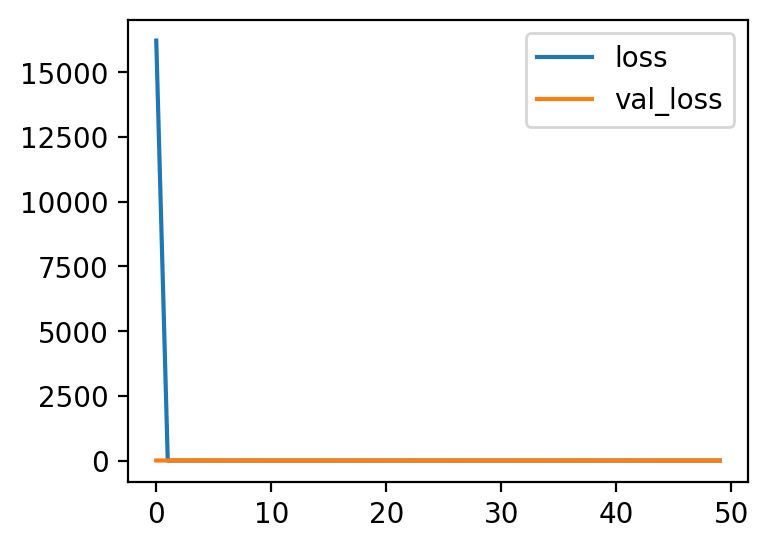

<Figure size 800x600 with 0 Axes>

{'loss': 0.7791168093681335, 'mse': 0.7791168093681335, 'val_loss': 1.0222020149230957, 'val_mse': 1.0222021341323853}
46/46 [==============================] - 1s 27ms/step - loss: 0.7791 - mse: 0.7791 - val_loss: 1.0222 - val_mse: 1.0222
Epoch 51/100
46/46 [==============================] - ETA: 0s - loss: 0.8416 - mse: 0.8416
Epoch 51: val_loss did not improve from 0.97060


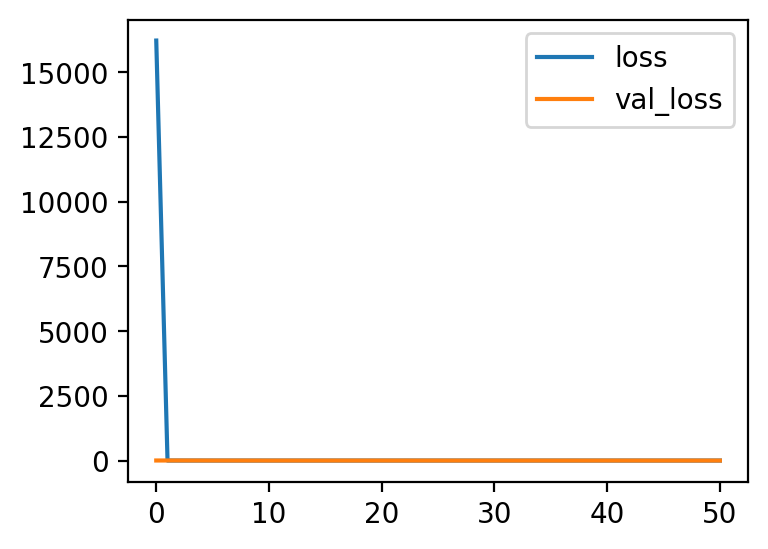

<Figure size 800x600 with 0 Axes>

{'loss': 0.8415803909301758, 'mse': 0.8415803909301758, 'val_loss': 1.1247602701187134, 'val_mse': 1.1247602701187134}
46/46 [==============================] - 1s 27ms/step - loss: 0.8416 - mse: 0.8416 - val_loss: 1.1248 - val_mse: 1.1248
Epoch 52/100
46/46 [==============================] - ETA: 0s - loss: 0.7569 - mse: 0.7569
Epoch 52: val_loss did not improve from 0.97060


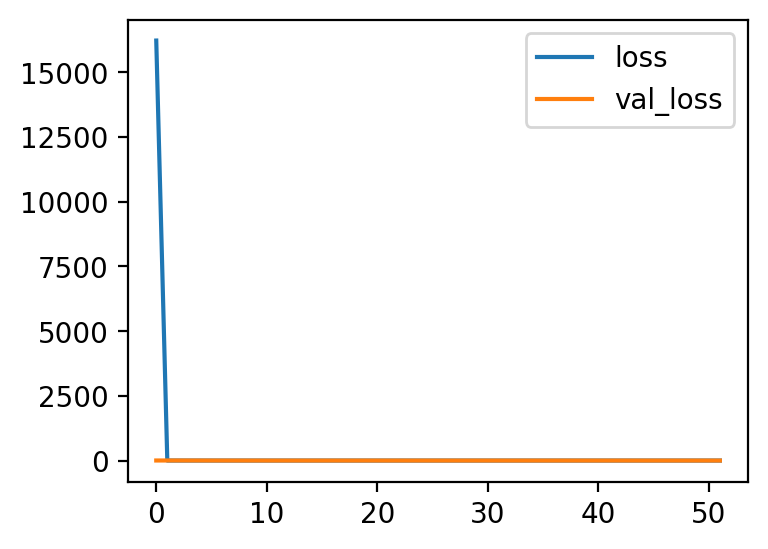

<Figure size 800x600 with 0 Axes>

{'loss': 0.7568826079368591, 'mse': 0.7568826079368591, 'val_loss': 1.1052594184875488, 'val_mse': 1.1052594184875488}
46/46 [==============================] - 1s 27ms/step - loss: 0.7569 - mse: 0.7569 - val_loss: 1.1053 - val_mse: 1.1053
Epoch 53/100
46/46 [==============================] - ETA: 0s - loss: 0.7219 - mse: 0.7219
Epoch 53: val_loss did not improve from 0.97060


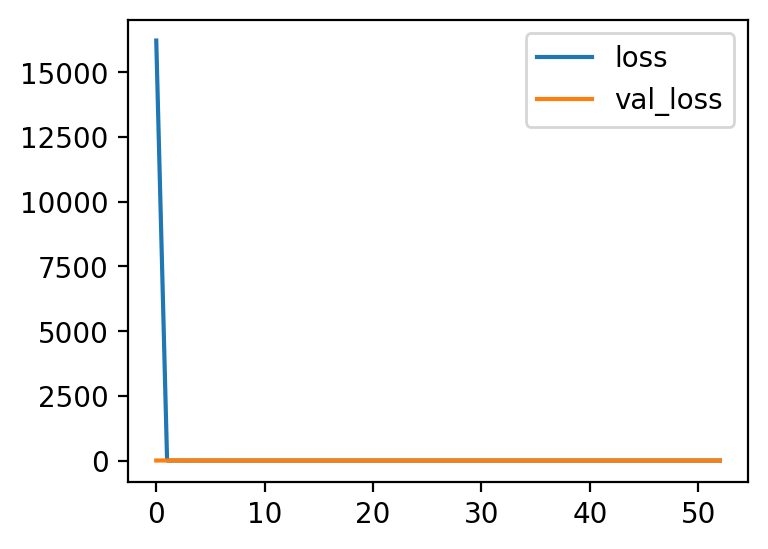

<Figure size 800x600 with 0 Axes>

{'loss': 0.7218871712684631, 'mse': 0.7218871712684631, 'val_loss': 1.166369915008545, 'val_mse': 1.166369915008545}
46/46 [==============================] - 1s 27ms/step - loss: 0.7219 - mse: 0.7219 - val_loss: 1.1664 - val_mse: 1.1664
Epoch 54/100
46/46 [==============================] - ETA: 0s - loss: 0.7517 - mse: 0.7517
Epoch 54: val_loss did not improve from 0.97060


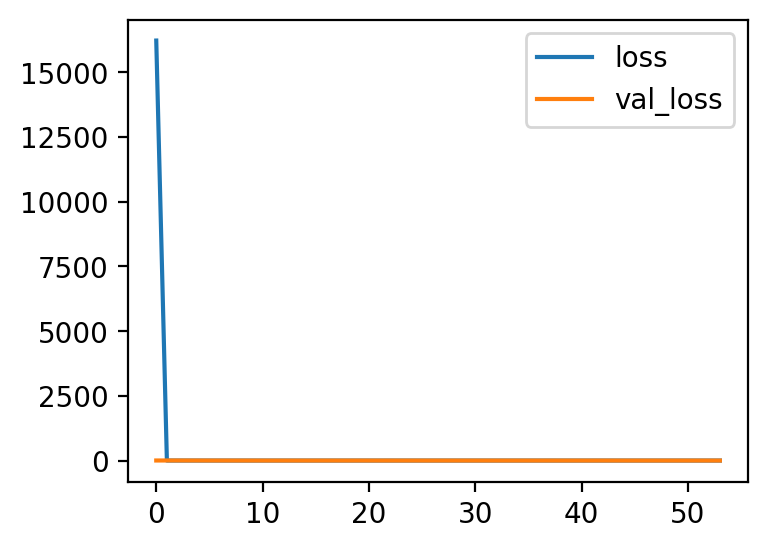

<Figure size 800x600 with 0 Axes>

{'loss': 0.7517175078392029, 'mse': 0.7517175078392029, 'val_loss': 1.1119693517684937, 'val_mse': 1.1119693517684937}
46/46 [==============================] - 1s 27ms/step - loss: 0.7517 - mse: 0.7517 - val_loss: 1.1120 - val_mse: 1.1120
Epoch 55/100
46/46 [==============================] - ETA: 0s - loss: 0.7507 - mse: 0.7507
Epoch 55: val_loss did not improve from 0.97060


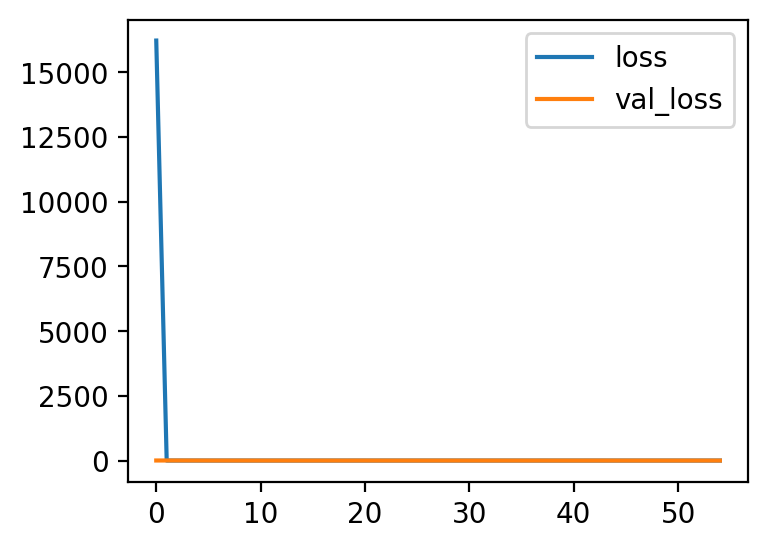

<Figure size 800x600 with 0 Axes>

{'loss': 0.7507246136665344, 'mse': 0.7507246136665344, 'val_loss': 1.1566526889801025, 'val_mse': 1.1566526889801025}
46/46 [==============================] - 1s 30ms/step - loss: 0.7507 - mse: 0.7507 - val_loss: 1.1567 - val_mse: 1.1567
Epoch 56/100
46/46 [==============================] - ETA: 0s - loss: 0.8074 - mse: 0.8074
Epoch 56: val_loss did not improve from 0.97060


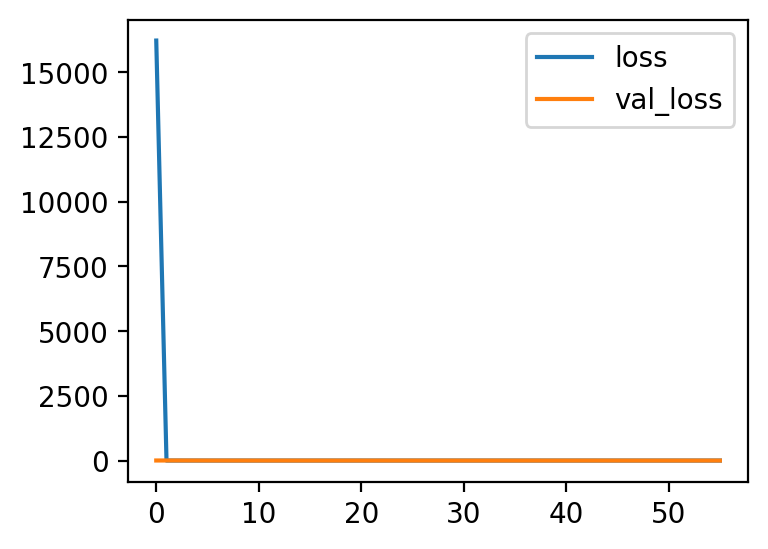

<Figure size 800x600 with 0 Axes>

{'loss': 0.8073516488075256, 'mse': 0.8073516488075256, 'val_loss': 1.2252756357192993, 'val_mse': 1.2252756357192993}
46/46 [==============================] - 1s 27ms/step - loss: 0.8074 - mse: 0.8074 - val_loss: 1.2253 - val_mse: 1.2253
Epoch 57/100
46/46 [==============================] - ETA: 0s - loss: 0.7974 - mse: 0.7974
Epoch 57: val_loss did not improve from 0.97060


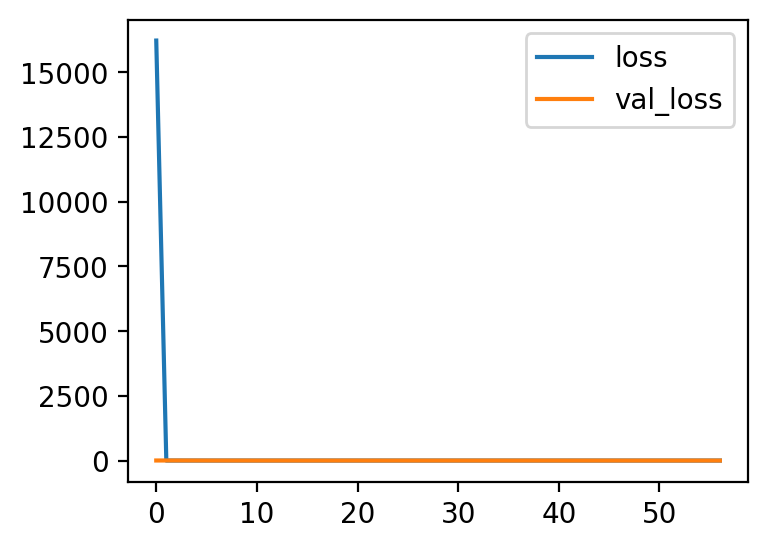

<Figure size 800x600 with 0 Axes>

{'loss': 0.7973669767379761, 'mse': 0.7973669767379761, 'val_loss': 1.1573094129562378, 'val_mse': 1.1573094129562378}
46/46 [==============================] - 1s 27ms/step - loss: 0.7974 - mse: 0.7974 - val_loss: 1.1573 - val_mse: 1.1573
Epoch 58/100
46/46 [==============================] - ETA: 0s - loss: 0.7255 - mse: 0.7255
Epoch 58: val_loss did not improve from 0.97060


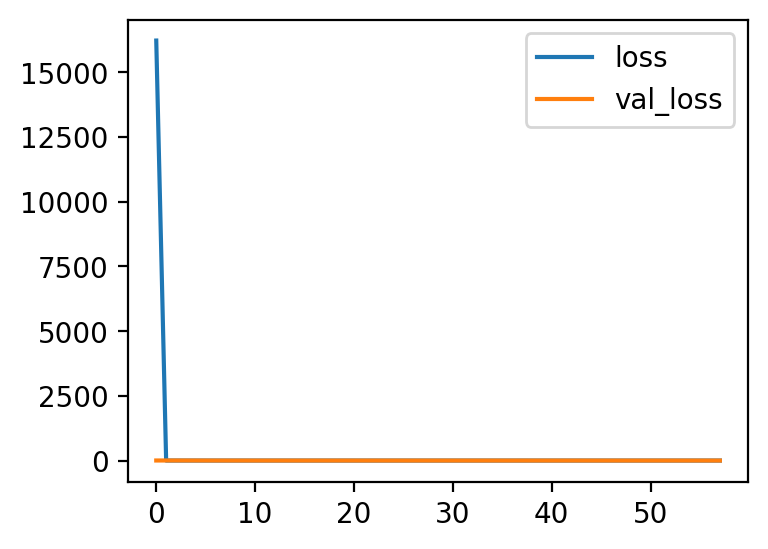

<Figure size 800x600 with 0 Axes>

{'loss': 0.7254719734191895, 'mse': 0.7254719734191895, 'val_loss': 1.0196173191070557, 'val_mse': 1.0196173191070557}
46/46 [==============================] - 1s 27ms/step - loss: 0.7255 - mse: 0.7255 - val_loss: 1.0196 - val_mse: 1.0196
Epoch 59/100
46/46 [==============================] - ETA: 0s - loss: 0.8064 - mse: 0.8064
Epoch 59: val_loss did not improve from 0.97060


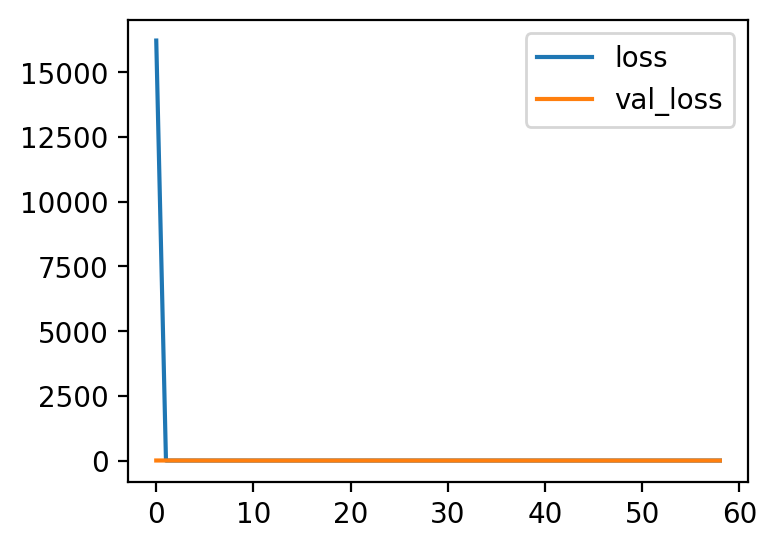

<Figure size 800x600 with 0 Axes>

{'loss': 0.8064013719558716, 'mse': 0.8064013719558716, 'val_loss': 1.4463881254196167, 'val_mse': 1.4463881254196167}
46/46 [==============================] - 1s 27ms/step - loss: 0.8064 - mse: 0.8064 - val_loss: 1.4464 - val_mse: 1.4464
Epoch 60/100
46/46 [==============================] - ETA: 0s - loss: 0.7621 - mse: 0.7621
Epoch 60: val_loss did not improve from 0.97060


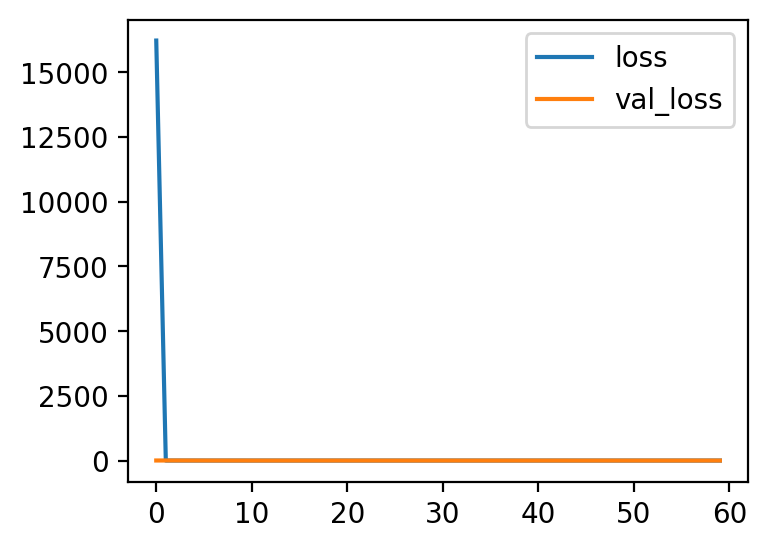

<Figure size 800x600 with 0 Axes>

{'loss': 0.762051522731781, 'mse': 0.762051522731781, 'val_loss': 1.2489746809005737, 'val_mse': 1.2489746809005737}
46/46 [==============================] - 1s 27ms/step - loss: 0.7621 - mse: 0.7621 - val_loss: 1.2490 - val_mse: 1.2490
Epoch 61/100
46/46 [==============================] - ETA: 0s - loss: 0.7425 - mse: 0.7425
Epoch 61: val_loss did not improve from 0.97060


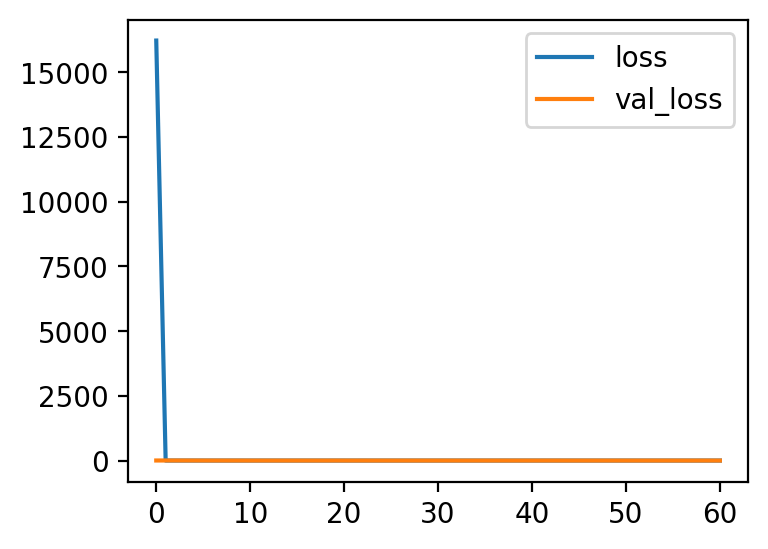

<Figure size 800x600 with 0 Axes>

{'loss': 0.7425150871276855, 'mse': 0.7425150871276855, 'val_loss': 1.0226861238479614, 'val_mse': 1.022686243057251}
46/46 [==============================] - 1s 27ms/step - loss: 0.7425 - mse: 0.7425 - val_loss: 1.0227 - val_mse: 1.0227
Epoch 62/100
46/46 [==============================] - ETA: 0s - loss: 0.7477 - mse: 0.7477
Epoch 62: val_loss did not improve from 0.97060


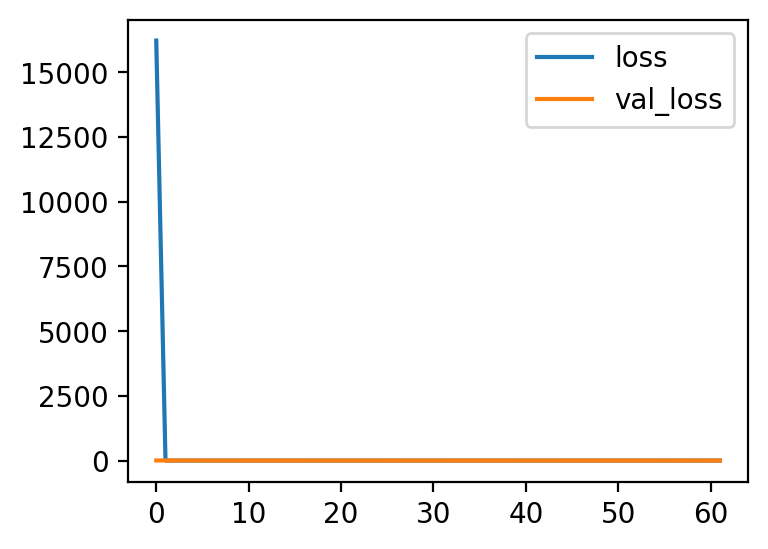

<Figure size 800x600 with 0 Axes>

{'loss': 0.7477153539657593, 'mse': 0.7477153539657593, 'val_loss': 1.1015607118606567, 'val_mse': 1.1015607118606567}
46/46 [==============================] - 1s 27ms/step - loss: 0.7477 - mse: 0.7477 - val_loss: 1.1016 - val_mse: 1.1016
Epoch 63/100
46/46 [==============================] - ETA: 0s - loss: 0.7810 - mse: 0.7810
Epoch 63: val_loss did not improve from 0.97060


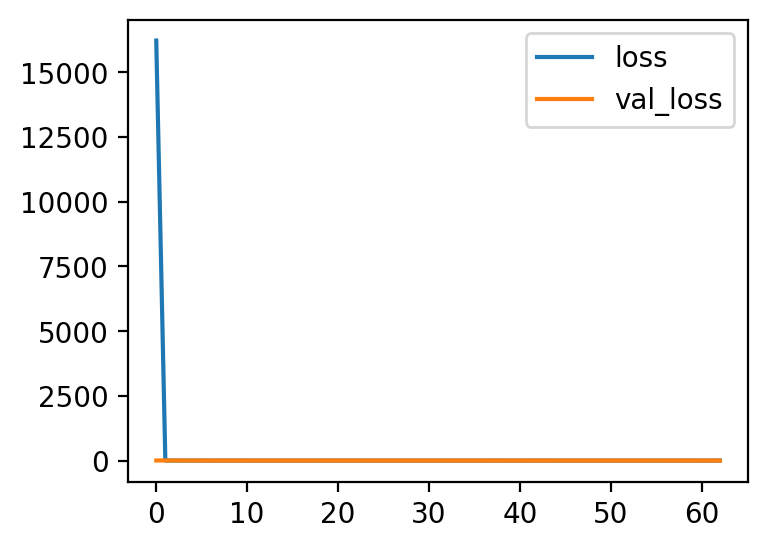

<Figure size 800x600 with 0 Axes>

{'loss': 0.7809762358665466, 'mse': 0.7809762358665466, 'val_loss': 1.3930193185806274, 'val_mse': 1.3930193185806274}
46/46 [==============================] - 1s 27ms/step - loss: 0.7810 - mse: 0.7810 - val_loss: 1.3930 - val_mse: 1.3930
Epoch 64/100
45/46 [============================>.] - ETA: 0s - loss: 0.8119 - mse: 0.8119
Epoch 64: val_loss did not improve from 0.97060


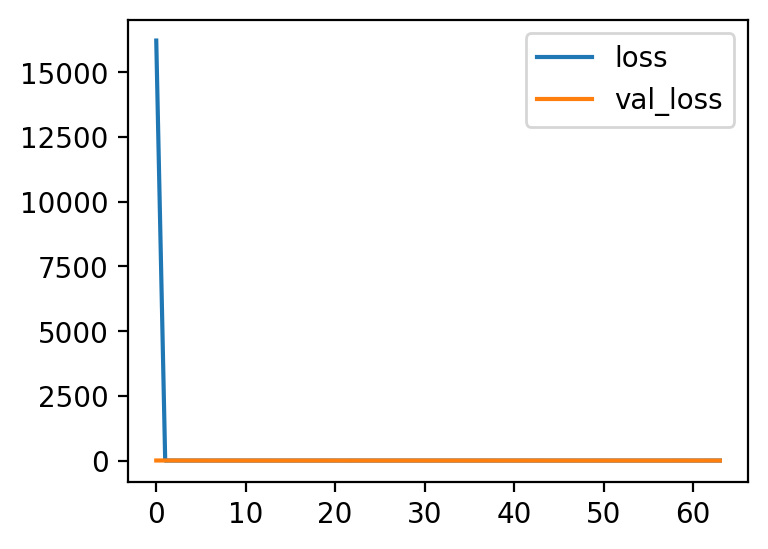

<Figure size 800x600 with 0 Axes>

{'loss': 0.8121153116226196, 'mse': 0.8121153116226196, 'val_loss': 1.2758220434188843, 'val_mse': 1.2758220434188843}
46/46 [==============================] - 1s 27ms/step - loss: 0.8121 - mse: 0.8121 - val_loss: 1.2758 - val_mse: 1.2758
Epoch 65/100
46/46 [==============================] - ETA: 0s - loss: 0.7482 - mse: 0.7482
Epoch 65: val_loss did not improve from 0.97060


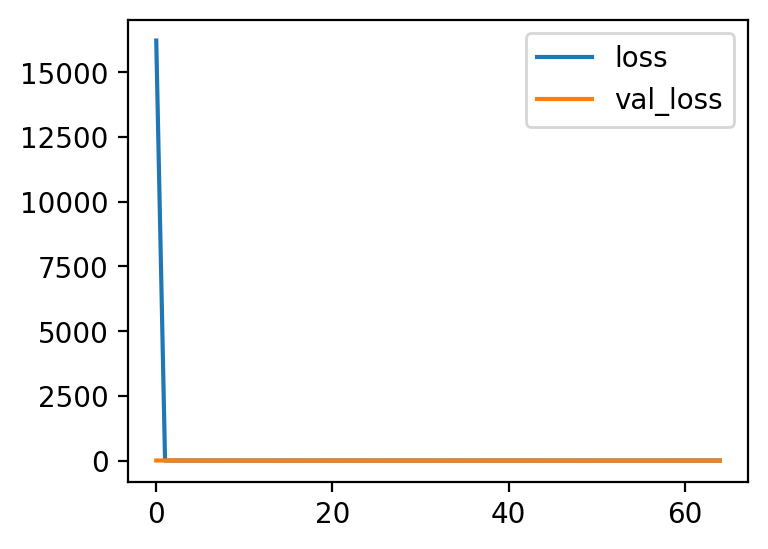

<Figure size 800x600 with 0 Axes>

{'loss': 0.7481622695922852, 'mse': 0.7481622695922852, 'val_loss': 1.1153638362884521, 'val_mse': 1.1153638362884521}
46/46 [==============================] - 1s 27ms/step - loss: 0.7482 - mse: 0.7482 - val_loss: 1.1154 - val_mse: 1.1154
Epoch 66/100
46/46 [==============================] - ETA: 0s - loss: 0.7398 - mse: 0.7398
Epoch 66: val_loss did not improve from 0.97060


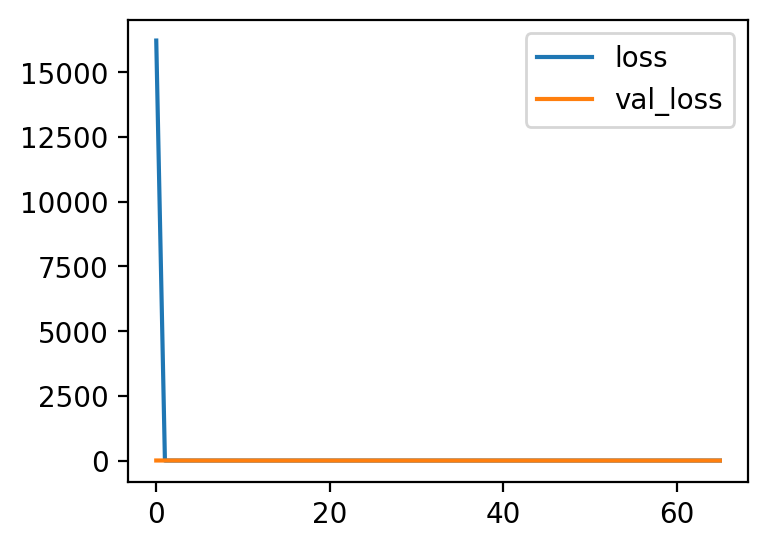

<Figure size 800x600 with 0 Axes>

{'loss': 0.739783525466919, 'mse': 0.739783525466919, 'val_loss': 1.0993428230285645, 'val_mse': 1.099342703819275}
46/46 [==============================] - 1s 27ms/step - loss: 0.7398 - mse: 0.7398 - val_loss: 1.0993 - val_mse: 1.0993
Epoch 67/100
46/46 [==============================] - ETA: 0s - loss: 0.7237 - mse: 0.7237
Epoch 67: val_loss did not improve from 0.97060


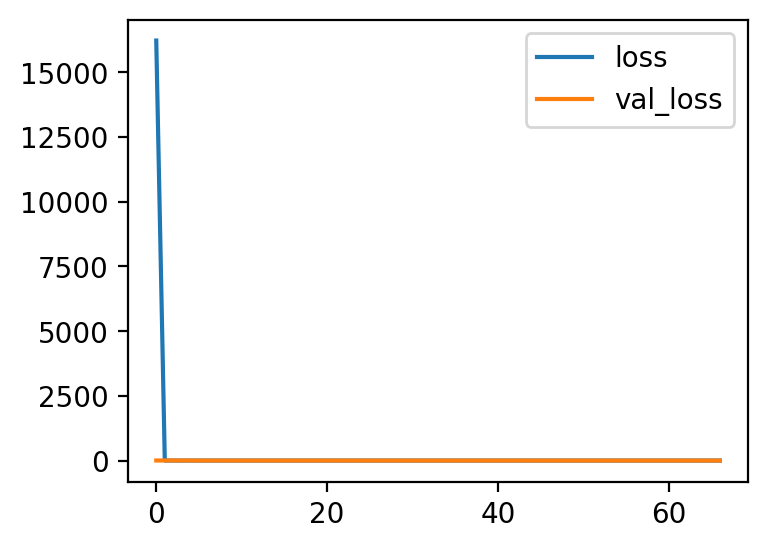

<Figure size 800x600 with 0 Axes>

{'loss': 0.7237383127212524, 'mse': 0.7237383127212524, 'val_loss': 1.0319740772247314, 'val_mse': 1.0319740772247314}
46/46 [==============================] - 1s 27ms/step - loss: 0.7237 - mse: 0.7237 - val_loss: 1.0320 - val_mse: 1.0320
Epoch 68/100
46/46 [==============================] - ETA: 0s - loss: 0.7427 - mse: 0.7427
Epoch 68: val_loss did not improve from 0.97060


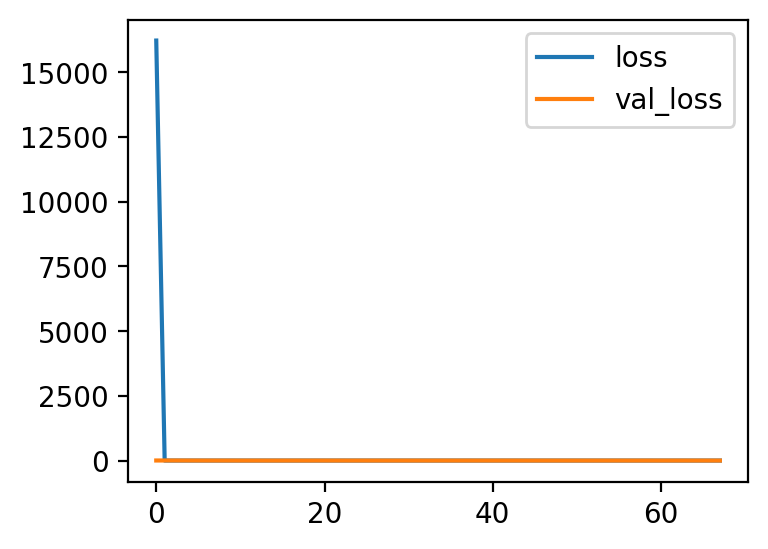

<Figure size 800x600 with 0 Axes>

{'loss': 0.7426583170890808, 'mse': 0.7426583170890808, 'val_loss': 1.0546163320541382, 'val_mse': 1.0546163320541382}
46/46 [==============================] - 1s 27ms/step - loss: 0.7427 - mse: 0.7427 - val_loss: 1.0546 - val_mse: 1.0546
Epoch 69/100
46/46 [==============================] - ETA: 0s - loss: 0.7688 - mse: 0.7688
Epoch 69: val_loss did not improve from 0.97060


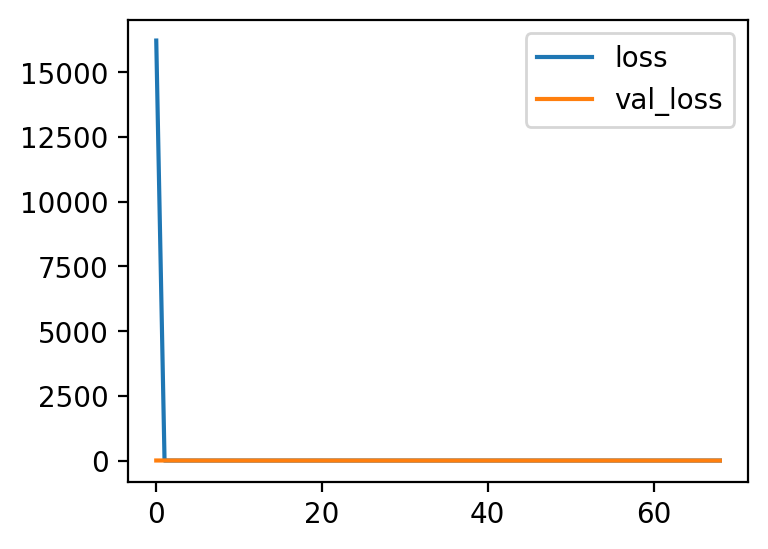

<Figure size 800x600 with 0 Axes>

{'loss': 0.7688010334968567, 'mse': 0.7688010334968567, 'val_loss': 1.0339657068252563, 'val_mse': 1.0339657068252563}
46/46 [==============================] - 1s 27ms/step - loss: 0.7688 - mse: 0.7688 - val_loss: 1.0340 - val_mse: 1.0340
Epoch 70/100
46/46 [==============================] - ETA: 0s - loss: 0.7437 - mse: 0.7437
Epoch 70: val_loss did not improve from 0.97060


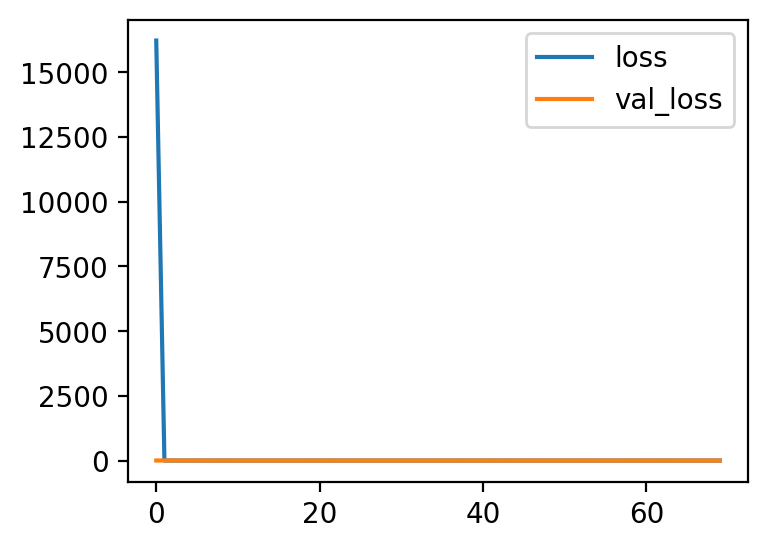

<Figure size 800x600 with 0 Axes>

{'loss': 0.7437156438827515, 'mse': 0.7437156438827515, 'val_loss': 1.104052186012268, 'val_mse': 1.104052186012268}
46/46 [==============================] - 1s 27ms/step - loss: 0.7437 - mse: 0.7437 - val_loss: 1.1041 - val_mse: 1.1041
Epoch 71/100
46/46 [==============================] - ETA: 0s - loss: 0.7335 - mse: 0.7335
Epoch 71: val_loss did not improve from 0.97060


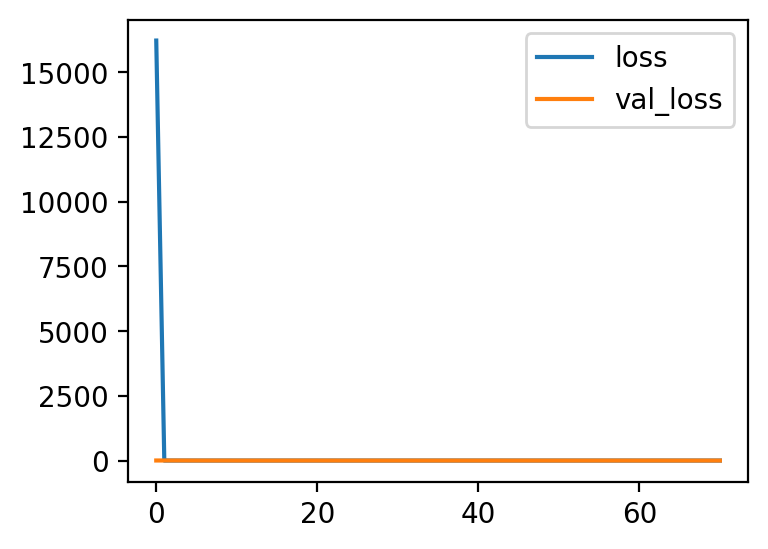

<Figure size 800x600 with 0 Axes>

{'loss': 0.7335047721862793, 'mse': 0.7335047721862793, 'val_loss': 1.0030745267868042, 'val_mse': 1.0030745267868042}
46/46 [==============================] - 1s 27ms/step - loss: 0.7335 - mse: 0.7335 - val_loss: 1.0031 - val_mse: 1.0031
Epoch 72/100
46/46 [==============================] - ETA: 0s - loss: 0.7104 - mse: 0.7104
Epoch 72: val_loss did not improve from 0.97060


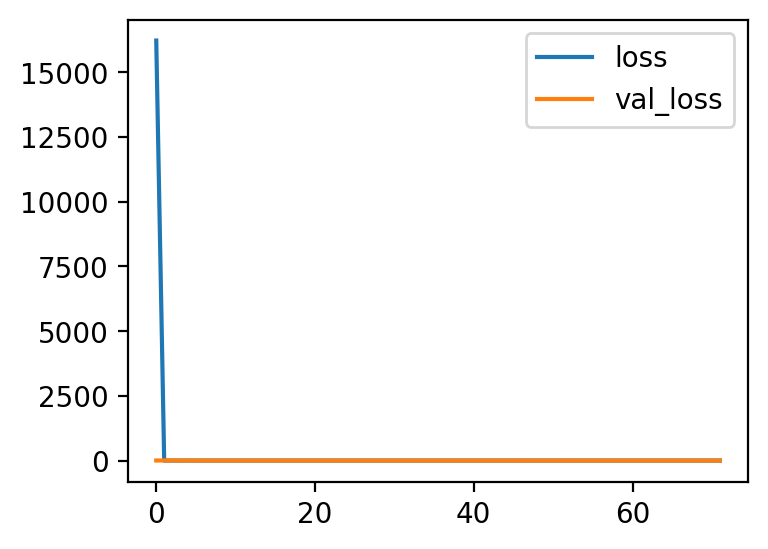

<Figure size 800x600 with 0 Axes>

{'loss': 0.7103676199913025, 'mse': 0.7103676199913025, 'val_loss': 0.9846360087394714, 'val_mse': 0.9846360087394714}
46/46 [==============================] - 1s 27ms/step - loss: 0.7104 - mse: 0.7104 - val_loss: 0.9846 - val_mse: 0.9846
Epoch 73/100
46/46 [==============================] - ETA: 0s - loss: 0.7180 - mse: 0.7180
Epoch 73: val_loss did not improve from 0.97060


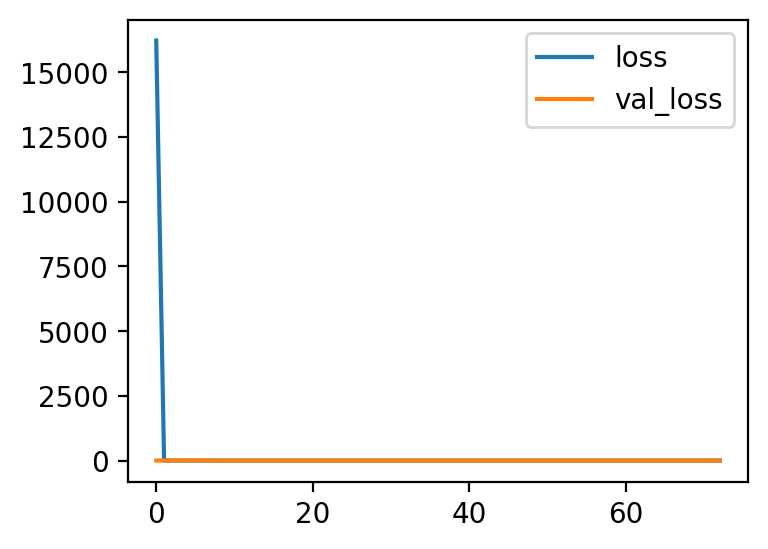

<Figure size 800x600 with 0 Axes>

{'loss': 0.7179595828056335, 'mse': 0.7179595828056335, 'val_loss': 1.196941614151001, 'val_mse': 1.196941614151001}
46/46 [==============================] - 1s 27ms/step - loss: 0.7180 - mse: 0.7180 - val_loss: 1.1969 - val_mse: 1.1969
Epoch 74/100
46/46 [==============================] - ETA: 0s - loss: 0.7304 - mse: 0.7304
Epoch 74: val_loss did not improve from 0.97060


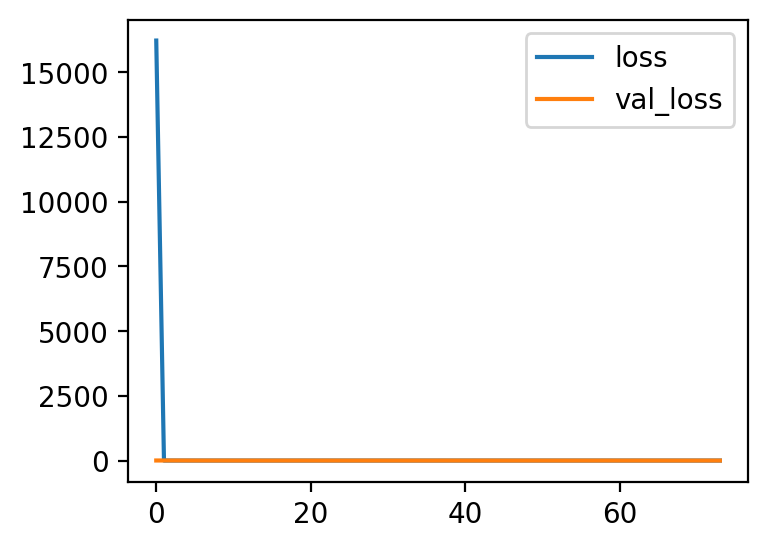

<Figure size 800x600 with 0 Axes>

{'loss': 0.7303768396377563, 'mse': 0.7303768396377563, 'val_loss': 1.0254524946212769, 'val_mse': 1.0254524946212769}
46/46 [==============================] - 1s 27ms/step - loss: 0.7304 - mse: 0.7304 - val_loss: 1.0255 - val_mse: 1.0255
Epoch 75/100
46/46 [==============================] - ETA: 0s - loss: 0.7205 - mse: 0.7205
Epoch 75: val_loss did not improve from 0.97060


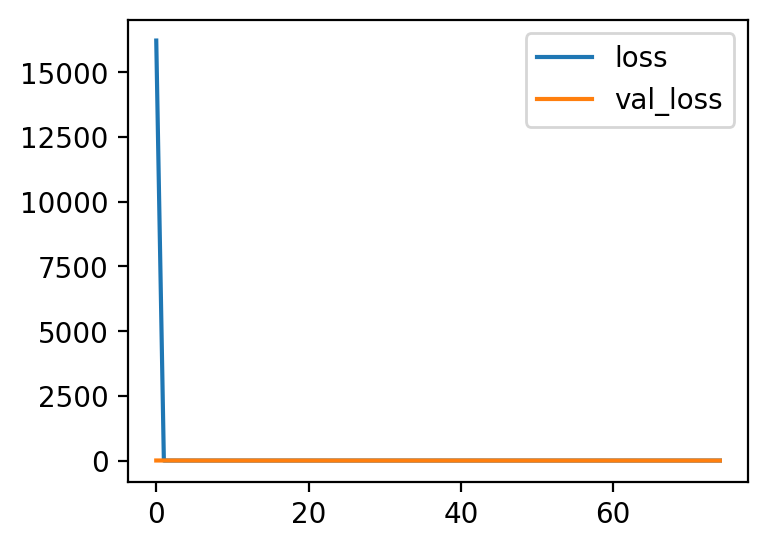

<Figure size 800x600 with 0 Axes>

{'loss': 0.720522403717041, 'mse': 0.720522403717041, 'val_loss': 1.101789116859436, 'val_mse': 1.101789116859436}
46/46 [==============================] - 1s 27ms/step - loss: 0.7205 - mse: 0.7205 - val_loss: 1.1018 - val_mse: 1.1018
Epoch 76/100
46/46 [==============================] - ETA: 0s - loss: 0.7415 - mse: 0.7415
Epoch 76: val_loss did not improve from 0.97060


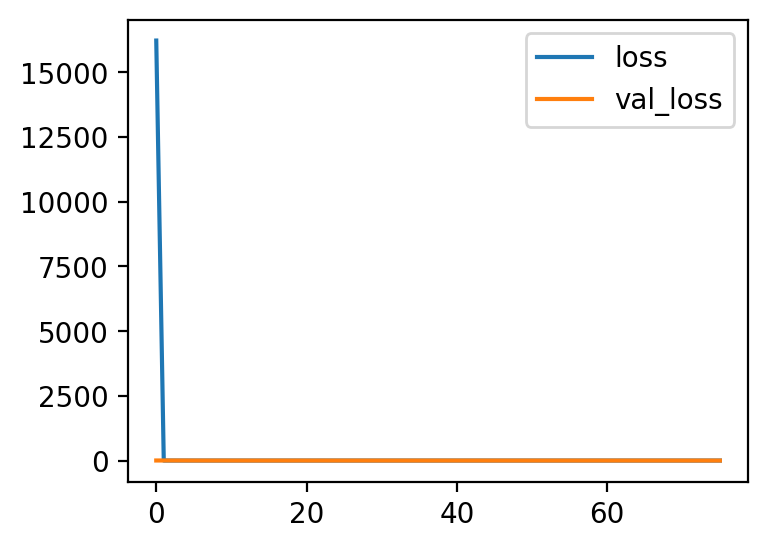

<Figure size 800x600 with 0 Axes>

{'loss': 0.7415185570716858, 'mse': 0.7415185570716858, 'val_loss': 1.0110180377960205, 'val_mse': 1.0110180377960205}
46/46 [==============================] - 1s 27ms/step - loss: 0.7415 - mse: 0.7415 - val_loss: 1.0110 - val_mse: 1.0110
Epoch 77/100
46/46 [==============================] - ETA: 0s - loss: 0.7501 - mse: 0.7501
Epoch 77: val_loss did not improve from 0.97060


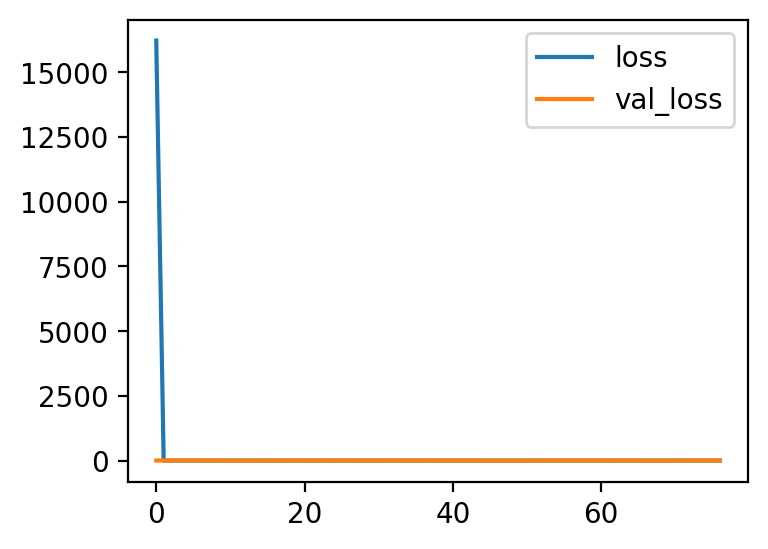

<Figure size 800x600 with 0 Axes>

{'loss': 0.7501025795936584, 'mse': 0.7501025795936584, 'val_loss': 1.2888062000274658, 'val_mse': 1.2888062000274658}
46/46 [==============================] - 1s 27ms/step - loss: 0.7501 - mse: 0.7501 - val_loss: 1.2888 - val_mse: 1.2888
Epoch 78/100
46/46 [==============================] - ETA: 0s - loss: 0.7392 - mse: 0.7392
Epoch 78: val_loss did not improve from 0.97060


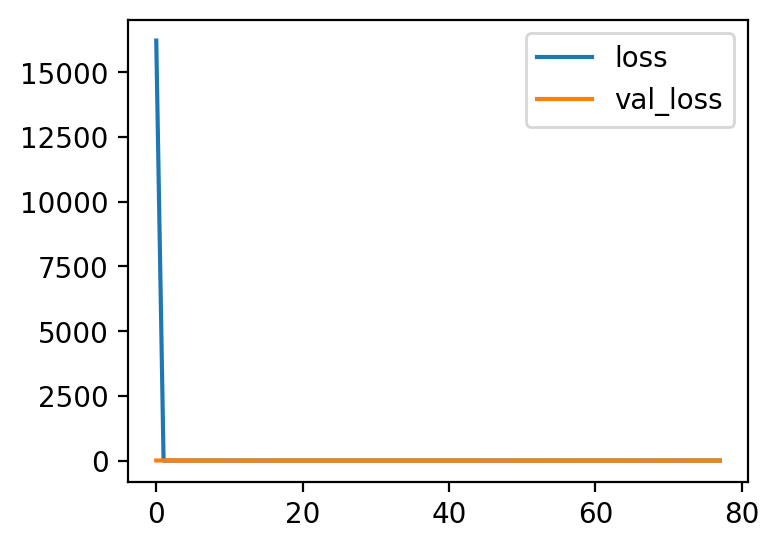

<Figure size 800x600 with 0 Axes>

{'loss': 0.7392457127571106, 'mse': 0.7392457127571106, 'val_loss': 1.0745704174041748, 'val_mse': 1.0745704174041748}
46/46 [==============================] - 1s 27ms/step - loss: 0.7392 - mse: 0.7392 - val_loss: 1.0746 - val_mse: 1.0746
Epoch 79/100
46/46 [==============================] - ETA: 0s - loss: 0.7643 - mse: 0.7643
Epoch 79: val_loss did not improve from 0.97060


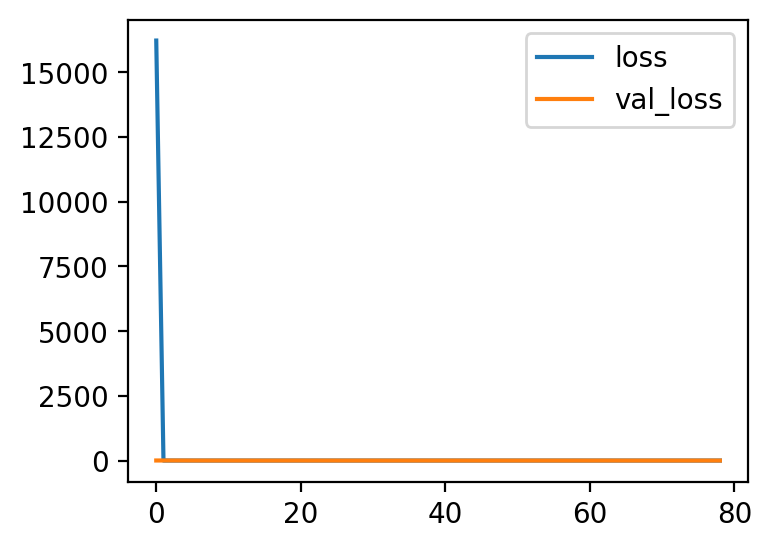

<Figure size 800x600 with 0 Axes>

{'loss': 0.7642722129821777, 'mse': 0.7642722129821777, 'val_loss': 1.2033953666687012, 'val_mse': 1.2033953666687012}
46/46 [==============================] - 1s 27ms/step - loss: 0.7643 - mse: 0.7643 - val_loss: 1.2034 - val_mse: 1.2034
Epoch 80/100
46/46 [==============================] - ETA: 0s - loss: 0.7401 - mse: 0.7401
Epoch 80: val_loss did not improve from 0.97060


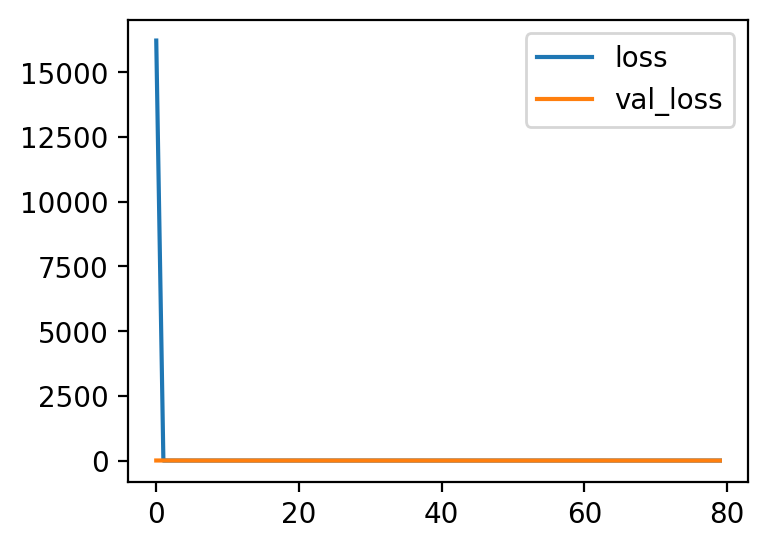

<Figure size 800x600 with 0 Axes>

{'loss': 0.7400540709495544, 'mse': 0.7400540709495544, 'val_loss': 1.0297898054122925, 'val_mse': 1.0297898054122925}
46/46 [==============================] - 1s 27ms/step - loss: 0.7401 - mse: 0.7401 - val_loss: 1.0298 - val_mse: 1.0298
Epoch 81/100
45/46 [============================>.] - ETA: 0s - loss: 0.7361 - mse: 0.7361
Epoch 81: val_loss did not improve from 0.97060


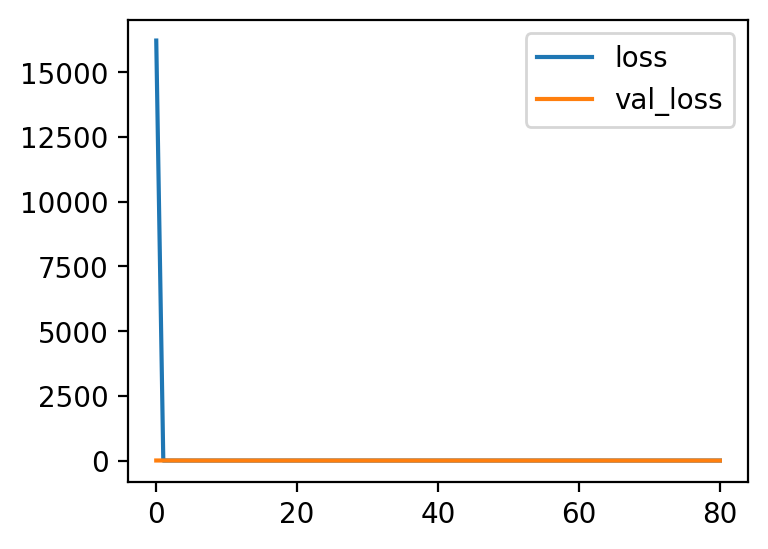

<Figure size 800x600 with 0 Axes>

{'loss': 0.7356505393981934, 'mse': 0.7356505393981934, 'val_loss': 1.0097339153289795, 'val_mse': 1.00973379611969}
46/46 [==============================] - 1s 27ms/step - loss: 0.7357 - mse: 0.7357 - val_loss: 1.0097 - val_mse: 1.0097
Epoch 82/100
46/46 [==============================] - ETA: 0s - loss: 0.7353 - mse: 0.7353
Epoch 82: val_loss did not improve from 0.97060


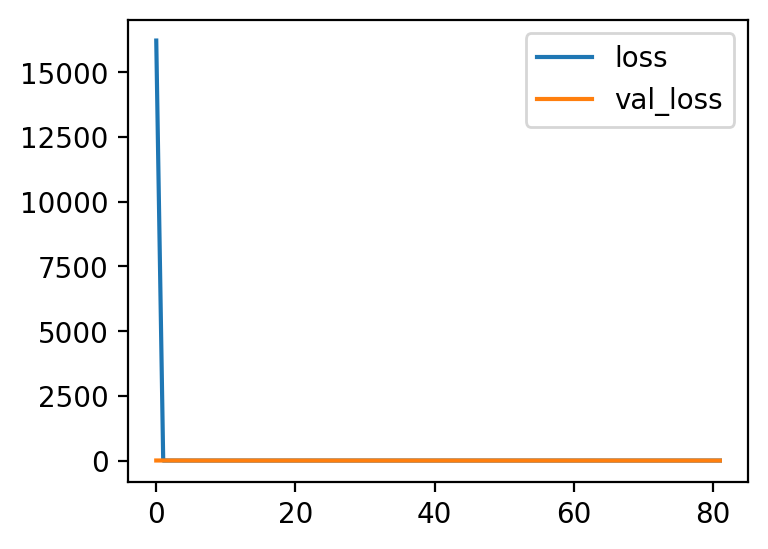

<Figure size 800x600 with 0 Axes>

{'loss': 0.7352879047393799, 'mse': 0.7352879047393799, 'val_loss': 1.0417077541351318, 'val_mse': 1.0417077541351318}
46/46 [==============================] - 1s 27ms/step - loss: 0.7353 - mse: 0.7353 - val_loss: 1.0417 - val_mse: 1.0417
Epoch 83/100
46/46 [==============================] - ETA: 0s - loss: 0.7203 - mse: 0.7203
Epoch 83: val_loss did not improve from 0.97060


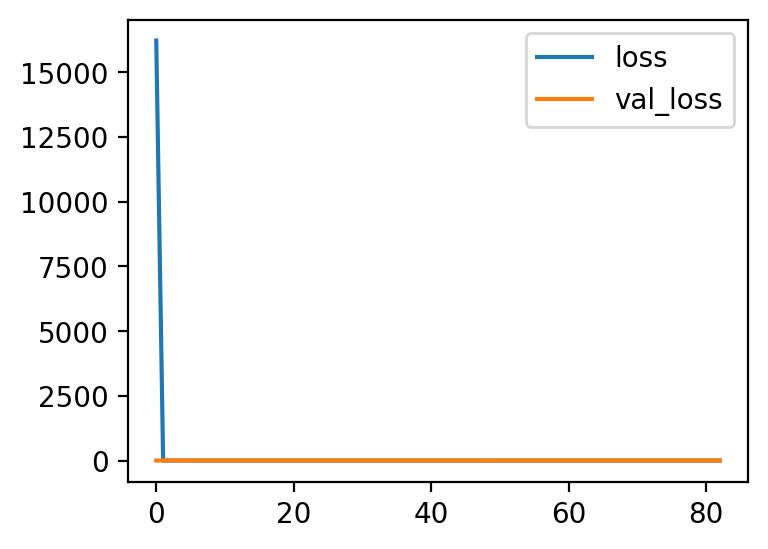

<Figure size 800x600 with 0 Axes>

{'loss': 0.7203269004821777, 'mse': 0.7203269004821777, 'val_loss': 1.0665467977523804, 'val_mse': 1.0665467977523804}
46/46 [==============================] - 1s 27ms/step - loss: 0.7203 - mse: 0.7203 - val_loss: 1.0665 - val_mse: 1.0665
Epoch 84/100
46/46 [==============================] - ETA: 0s - loss: 0.7187 - mse: 0.7187
Epoch 84: val_loss did not improve from 0.97060


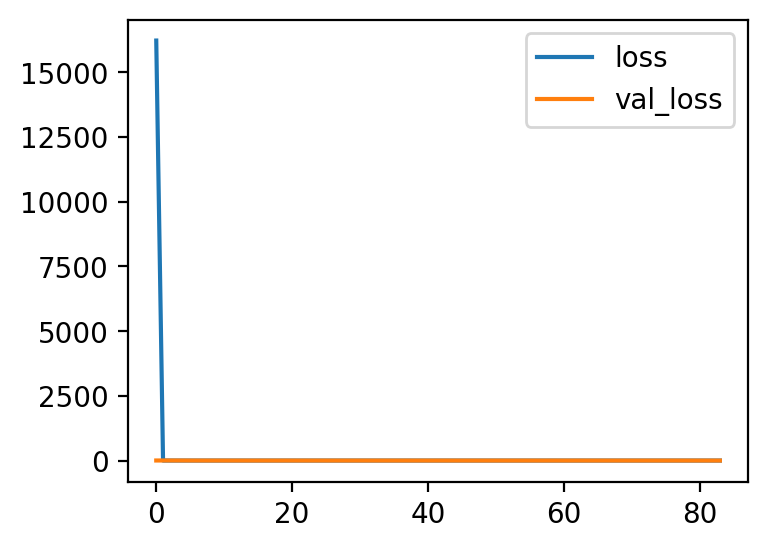

<Figure size 800x600 with 0 Axes>

{'loss': 0.7187074422836304, 'mse': 0.7187074422836304, 'val_loss': 1.054998517036438, 'val_mse': 1.054998517036438}
46/46 [==============================] - 1s 27ms/step - loss: 0.7187 - mse: 0.7187 - val_loss: 1.0550 - val_mse: 1.0550
Epoch 85/100
46/46 [==============================] - ETA: 0s - loss: 0.7166 - mse: 0.7166
Epoch 85: val_loss did not improve from 0.97060


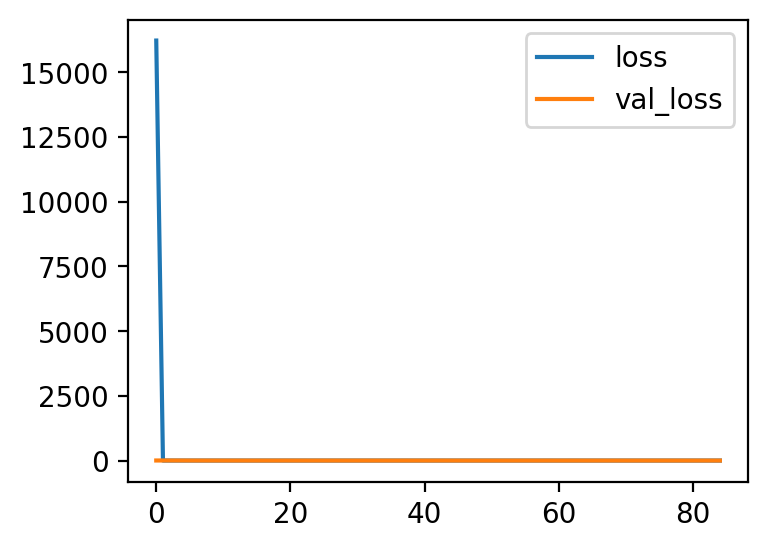

<Figure size 800x600 with 0 Axes>

{'loss': 0.7166037559509277, 'mse': 0.7166037559509277, 'val_loss': 1.02753484249115, 'val_mse': 1.02753484249115}
46/46 [==============================] - 1s 27ms/step - loss: 0.7166 - mse: 0.7166 - val_loss: 1.0275 - val_mse: 1.0275
Epoch 86/100
46/46 [==============================] - ETA: 0s - loss: 0.7434 - mse: 0.7434
Epoch 86: val_loss did not improve from 0.97060


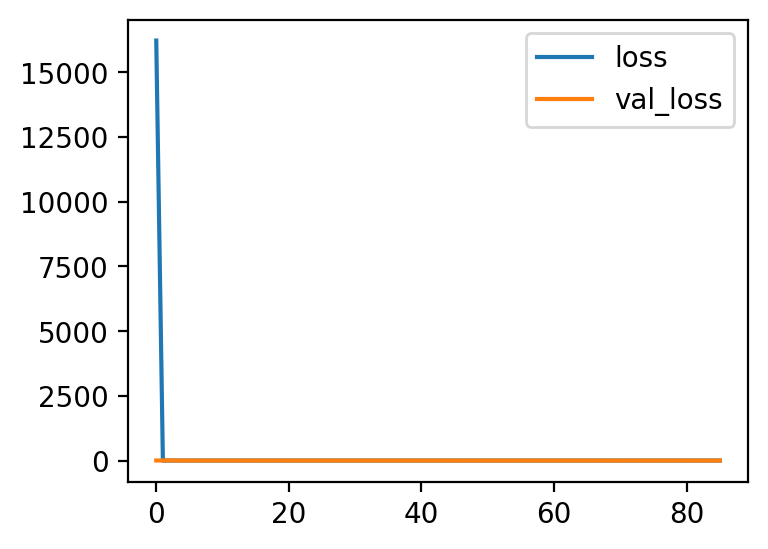

<Figure size 800x600 with 0 Axes>

{'loss': 0.7433983683586121, 'mse': 0.7433983683586121, 'val_loss': 1.2655398845672607, 'val_mse': 1.2655398845672607}
46/46 [==============================] - 1s 27ms/step - loss: 0.7434 - mse: 0.7434 - val_loss: 1.2655 - val_mse: 1.2655
Epoch 87/100
46/46 [==============================] - ETA: 0s - loss: 0.7308 - mse: 0.7308
Epoch 87: val_loss did not improve from 0.97060


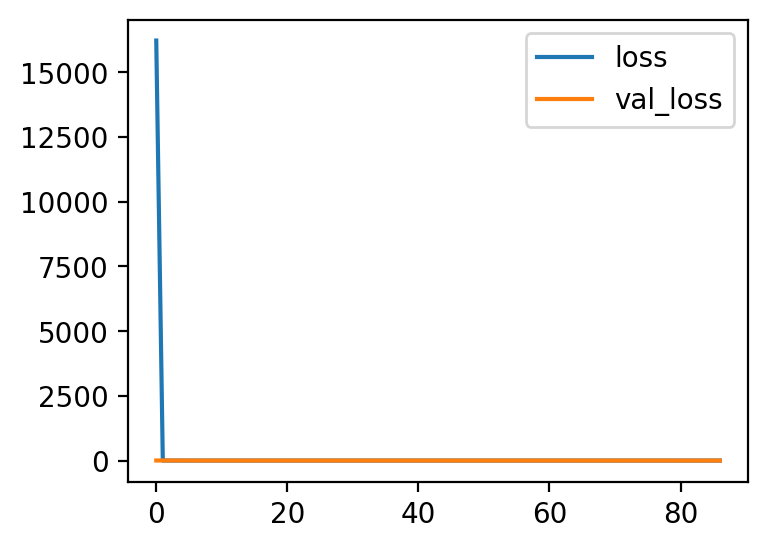

<Figure size 800x600 with 0 Axes>

{'loss': 0.7307592630386353, 'mse': 0.7307592630386353, 'val_loss': 1.0408793687820435, 'val_mse': 1.0408793687820435}
46/46 [==============================] - 1s 27ms/step - loss: 0.7308 - mse: 0.7308 - val_loss: 1.0409 - val_mse: 1.0409
Epoch 88/100
46/46 [==============================] - ETA: 0s - loss: 0.7241 - mse: 0.7241
Epoch 88: val_loss did not improve from 0.97060


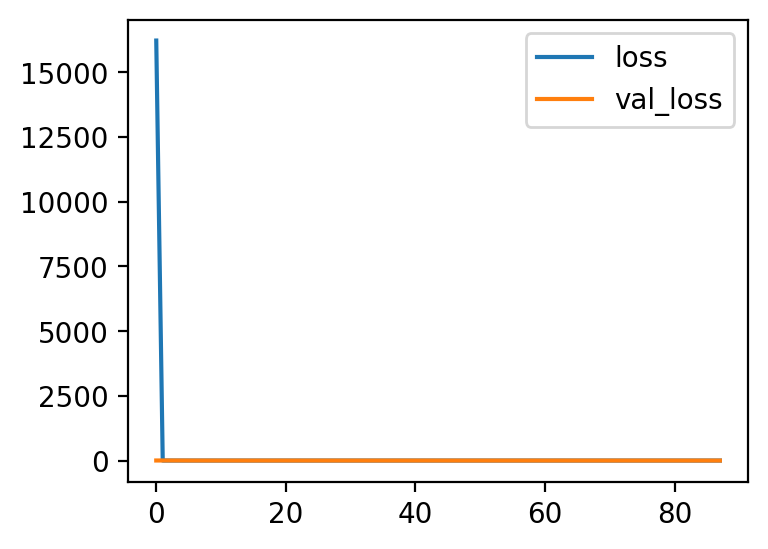

<Figure size 800x600 with 0 Axes>

{'loss': 0.7240860462188721, 'mse': 0.7240860462188721, 'val_loss': 1.0812736749649048, 'val_mse': 1.0812736749649048}
46/46 [==============================] - 1s 27ms/step - loss: 0.7241 - mse: 0.7241 - val_loss: 1.0813 - val_mse: 1.0813
Epoch 89/100
46/46 [==============================] - ETA: 0s - loss: 0.7160 - mse: 0.7160
Epoch 89: val_loss did not improve from 0.97060


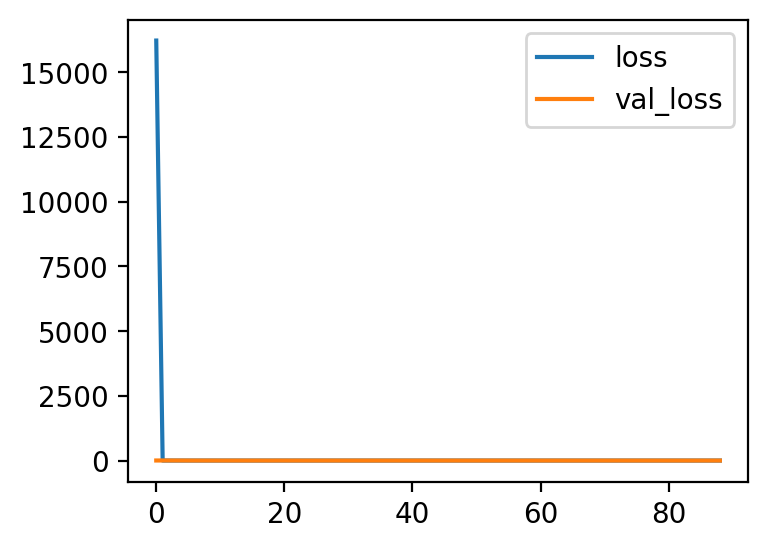

<Figure size 800x600 with 0 Axes>

{'loss': 0.7160334587097168, 'mse': 0.7160334587097168, 'val_loss': 1.2329766750335693, 'val_mse': 1.2329766750335693}
46/46 [==============================] - 1s 27ms/step - loss: 0.7160 - mse: 0.7160 - val_loss: 1.2330 - val_mse: 1.2330
Epoch 90/100
46/46 [==============================] - ETA: 0s - loss: 0.7329 - mse: 0.7329
Epoch 90: val_loss improved from 0.97060 to 0.95955, saving model to models/dscovrmatic-conv1d-v1-e90
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 53, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd052e0d0>, 139980775062864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04e3670>, 139980775432880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd047e0a0>, 139980774886176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(32,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0482b80>, 139980774886016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 32, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04a17c0>, 139980774937424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(64,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0437880>, 139980774937184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 64, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0445790>, 139980774964480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd045b880>, 139980774964240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd046c790>, 139980774980064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03ff820>, 139980775000368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1102848, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd0410700>, 139980774520352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd04237f0>, 139980774520832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03b56d0>, 139980774521872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f4fd03c47f0>, 139980774519312), {}).


INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e90/assets


INFO:tensorflow:Assets written to: models/dscovrmatic-conv1d-v1-e90/assets


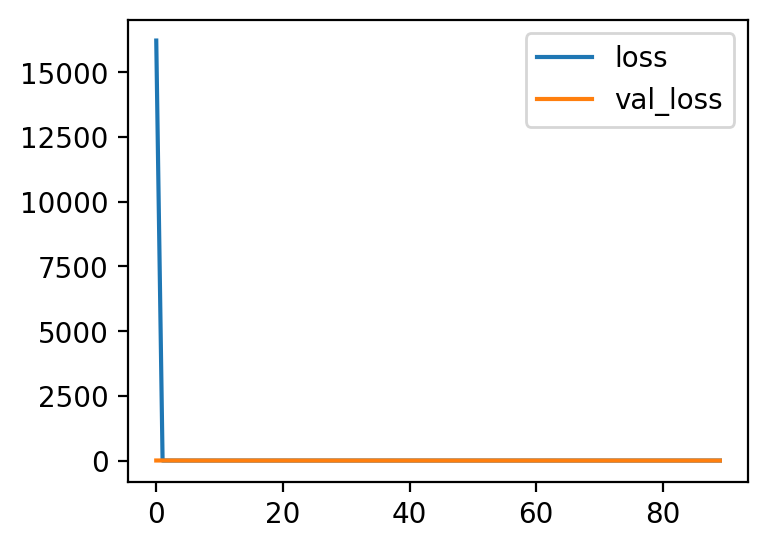

<Figure size 800x600 with 0 Axes>

{'loss': 0.7329040765762329, 'mse': 0.7329040765762329, 'val_loss': 0.9595523476600647, 'val_mse': 0.9595523476600647}
46/46 [==============================] - 3s 75ms/step - loss: 0.7329 - mse: 0.7329 - val_loss: 0.9596 - val_mse: 0.9596
Epoch 91/100
46/46 [==============================] - ETA: 0s - loss: 0.7612 - mse: 0.7612
Epoch 91: val_loss did not improve from 0.95955


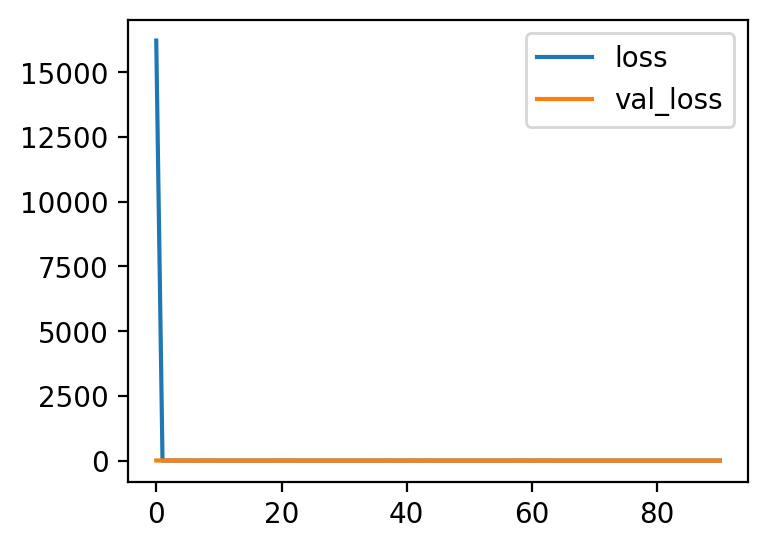

<Figure size 800x600 with 0 Axes>

{'loss': 0.7611974477767944, 'mse': 0.7611974477767944, 'val_loss': 1.0459647178649902, 'val_mse': 1.0459647178649902}
46/46 [==============================] - 1s 27ms/step - loss: 0.7612 - mse: 0.7612 - val_loss: 1.0460 - val_mse: 1.0460
Epoch 92/100
46/46 [==============================] - ETA: 0s - loss: 0.7573 - mse: 0.7573
Epoch 92: val_loss did not improve from 0.95955


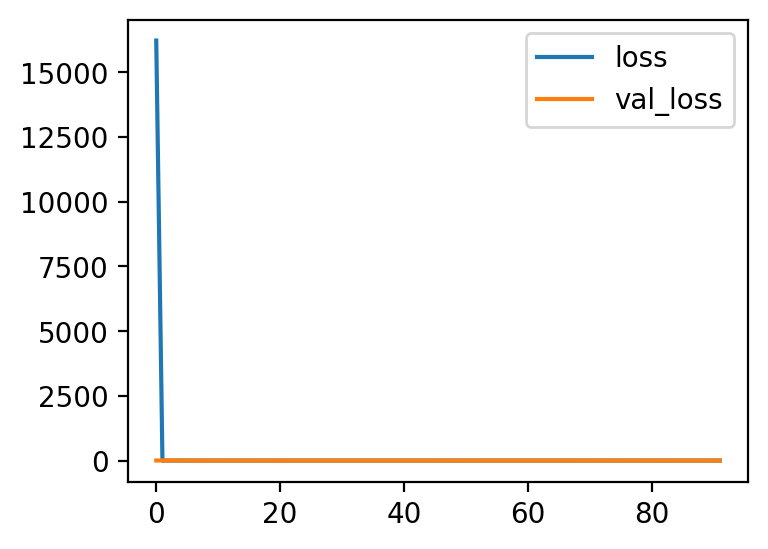

<Figure size 800x600 with 0 Axes>

{'loss': 0.7573357224464417, 'mse': 0.7573357224464417, 'val_loss': 1.1432321071624756, 'val_mse': 1.1432321071624756}
46/46 [==============================] - 1s 27ms/step - loss: 0.7573 - mse: 0.7573 - val_loss: 1.1432 - val_mse: 1.1432
Epoch 93/100
46/46 [==============================] - ETA: 0s - loss: 0.7339 - mse: 0.7339
Epoch 93: val_loss did not improve from 0.95955


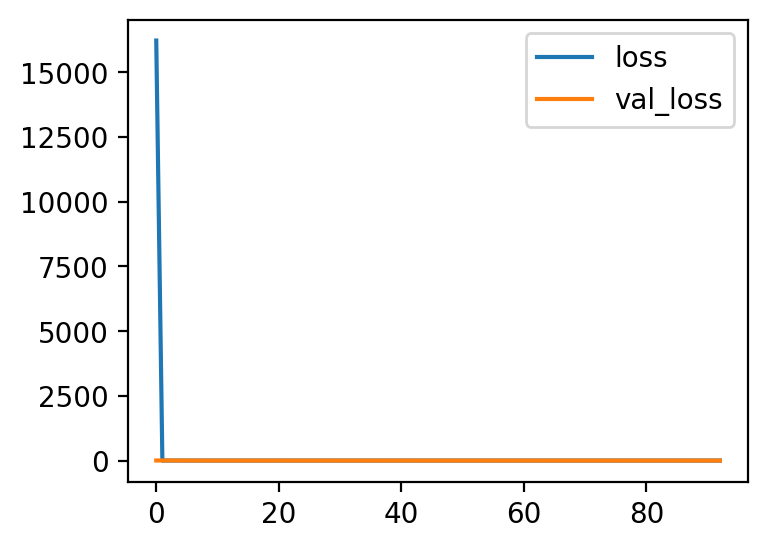

<Figure size 800x600 with 0 Axes>

{'loss': 0.7339308261871338, 'mse': 0.7339308261871338, 'val_loss': 1.1058391332626343, 'val_mse': 1.1058391332626343}
46/46 [==============================] - 1s 27ms/step - loss: 0.7339 - mse: 0.7339 - val_loss: 1.1058 - val_mse: 1.1058
Epoch 94/100
46/46 [==============================] - ETA: 0s - loss: 0.7560 - mse: 0.7560
Epoch 94: val_loss did not improve from 0.95955


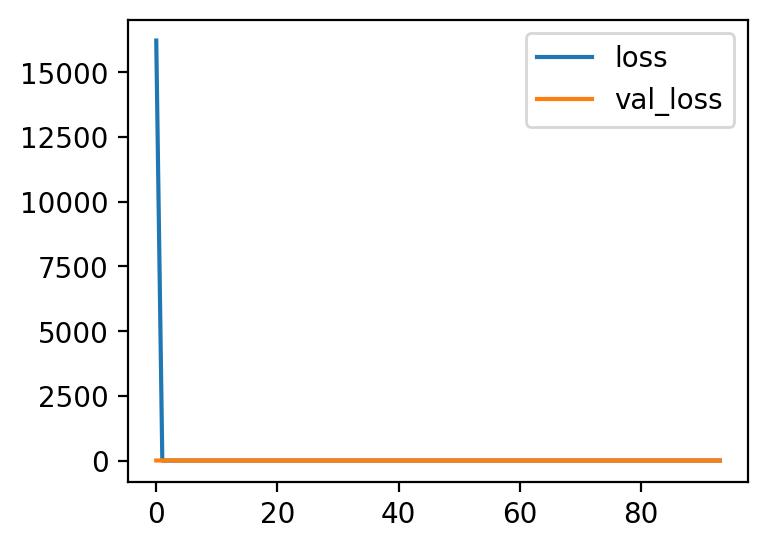

<Figure size 800x600 with 0 Axes>

{'loss': 0.7560421228408813, 'mse': 0.7560421228408813, 'val_loss': 1.1530014276504517, 'val_mse': 1.1530014276504517}
46/46 [==============================] - 1s 27ms/step - loss: 0.7560 - mse: 0.7560 - val_loss: 1.1530 - val_mse: 1.1530
Epoch 95/100
46/46 [==============================] - ETA: 0s - loss: 0.7143 - mse: 0.7143
Epoch 95: val_loss did not improve from 0.95955


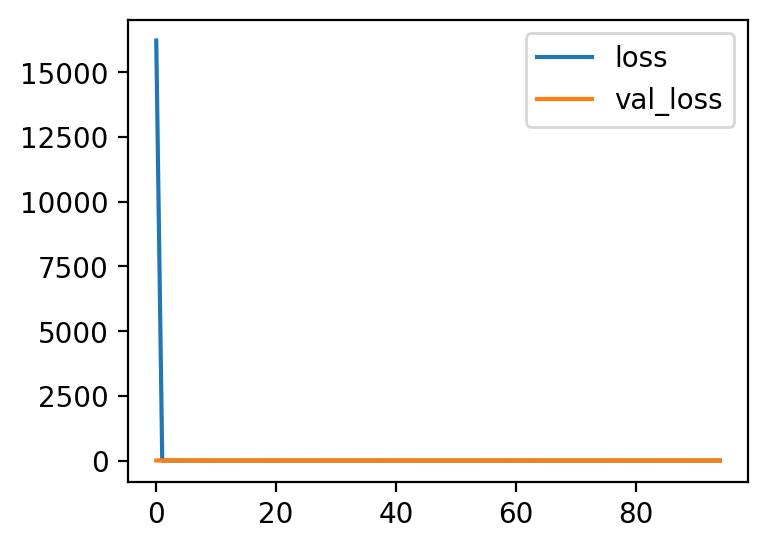

<Figure size 800x600 with 0 Axes>

{'loss': 0.7143375277519226, 'mse': 0.7143375277519226, 'val_loss': 0.9826728701591492, 'val_mse': 0.9826728701591492}
46/46 [==============================] - 1s 27ms/step - loss: 0.7143 - mse: 0.7143 - val_loss: 0.9827 - val_mse: 0.9827
Epoch 96/100
46/46 [==============================] - ETA: 0s - loss: 0.7343 - mse: 0.7343
Epoch 96: val_loss did not improve from 0.95955


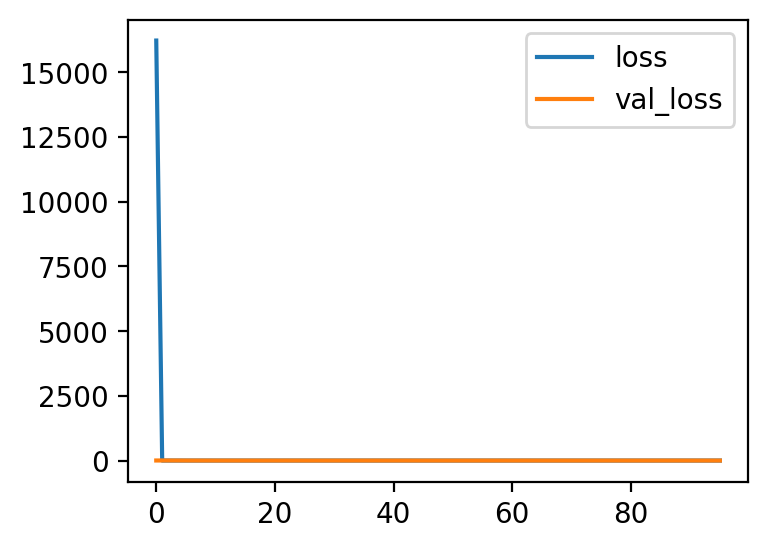

<Figure size 800x600 with 0 Axes>

{'loss': 0.7342991232872009, 'mse': 0.7342991232872009, 'val_loss': 1.153810739517212, 'val_mse': 1.153810739517212}
46/46 [==============================] - 1s 27ms/step - loss: 0.7343 - mse: 0.7343 - val_loss: 1.1538 - val_mse: 1.1538
Epoch 97/100
46/46 [==============================] - ETA: 0s - loss: 0.7297 - mse: 0.7297
Epoch 97: val_loss did not improve from 0.95955


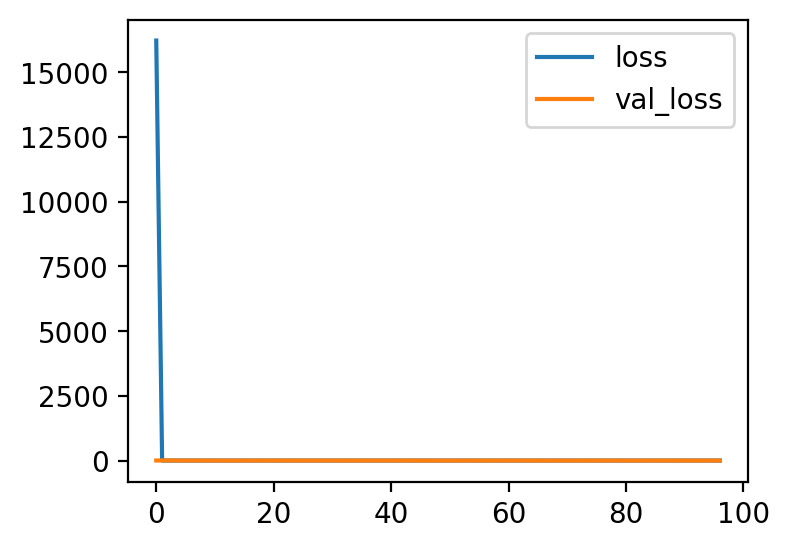

<Figure size 800x600 with 0 Axes>

{'loss': 0.7296515703201294, 'mse': 0.7296515703201294, 'val_loss': 1.225464105606079, 'val_mse': 1.225464105606079}
46/46 [==============================] - 1s 27ms/step - loss: 0.7297 - mse: 0.7297 - val_loss: 1.2255 - val_mse: 1.2255
Epoch 98/100
45/46 [============================>.] - ETA: 0s - loss: 0.7488 - mse: 0.7488
Epoch 98: val_loss did not improve from 0.95955


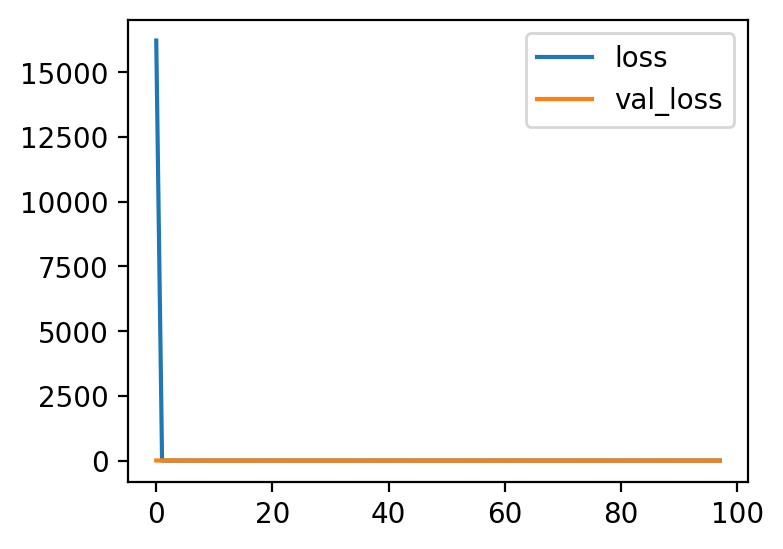

<Figure size 800x600 with 0 Axes>

{'loss': 0.748734712600708, 'mse': 0.748734712600708, 'val_loss': 1.0592397451400757, 'val_mse': 1.0592397451400757}
46/46 [==============================] - 1s 27ms/step - loss: 0.7487 - mse: 0.7487 - val_loss: 1.0592 - val_mse: 1.0592
Epoch 99/100
46/46 [==============================] - ETA: 0s - loss: 0.7331 - mse: 0.7331
Epoch 99: val_loss did not improve from 0.95955


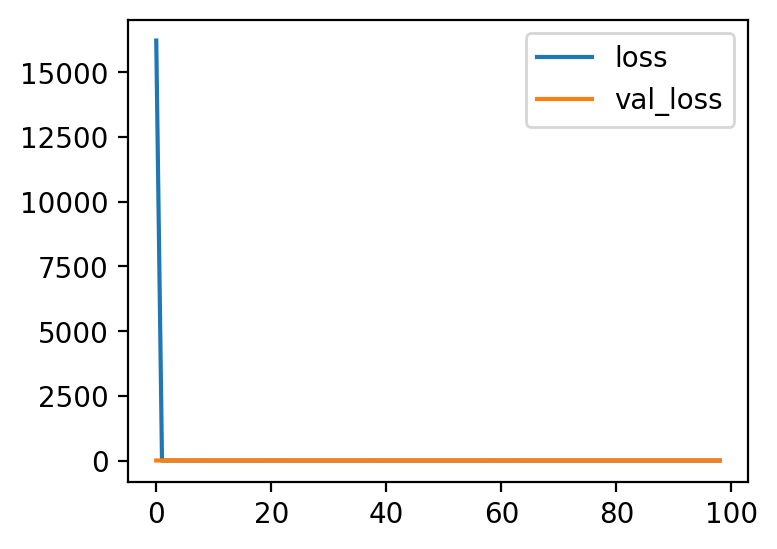

<Figure size 800x600 with 0 Axes>

{'loss': 0.7330517172813416, 'mse': 0.7330517172813416, 'val_loss': 0.9790799021720886, 'val_mse': 0.9790799021720886}
46/46 [==============================] - 1s 27ms/step - loss: 0.7331 - mse: 0.7331 - val_loss: 0.9791 - val_mse: 0.9791
Epoch 100/100
46/46 [==============================] - ETA: 0s - loss: 0.7349 - mse: 0.7349
Epoch 100: val_loss did not improve from 0.95955


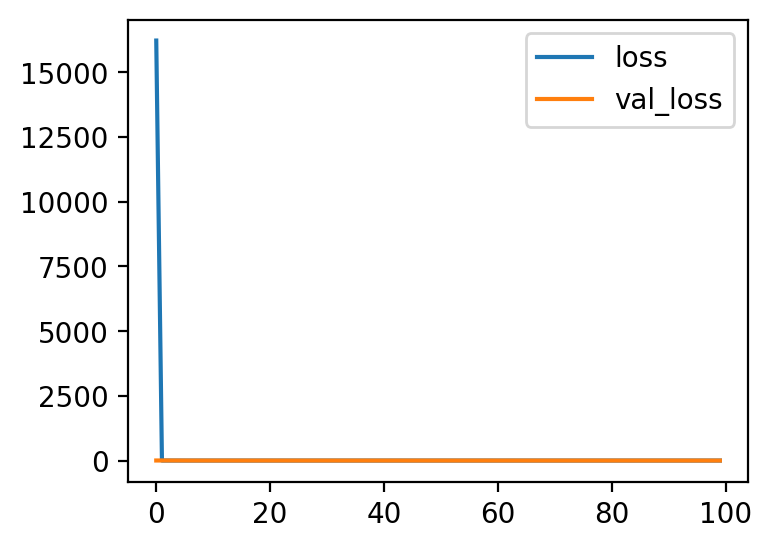

<Figure size 800x600 with 0 Axes>

{'loss': 0.7349146008491516, 'mse': 0.7349146008491516, 'val_loss': 1.2803120613098145, 'val_mse': 1.2803120613098145}
46/46 [==============================] - 1s 27ms/step - loss: 0.7349 - mse: 0.7349 - val_loss: 1.2803 - val_mse: 1.2803


In [17]:
model.fit(train_X, train_Y, validation_data=(valid_X, valid_Y), epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=1, shuffle=1)
bestEpoch = bestepoch.get_best_epoch()

In [36]:
bestEpoch=11
filepath="models/dscovrmatic-conv1d-v1-e%d" % (bestEpoch)
model = load_model(filepath)

In [37]:
test_X = valid_X[[0,25,100,116,73,95,44]]
test_Y = valid_Y[[0,25,100,116,73,95,44]]
y_hat = model.predict(test_X)

1/1 [==============================] - 0s 90ms/step


In [44]:
for i in range(test_Y.shape[0]):
  print('Predicted: %2.2f Truth: %2.2f' %(y_hat[i], test_Y[i]))

Predicted: 1.50 Truth: 2.00
Predicted: 2.03 Truth: 2.00
Predicted: 1.69 Truth: 2.00
Predicted: 3.34 Truth: 3.00
Predicted: 2.06 Truth: 1.00
Predicted: 1.69 Truth: 1.00
Predicted: 2.01 Truth: 1.00


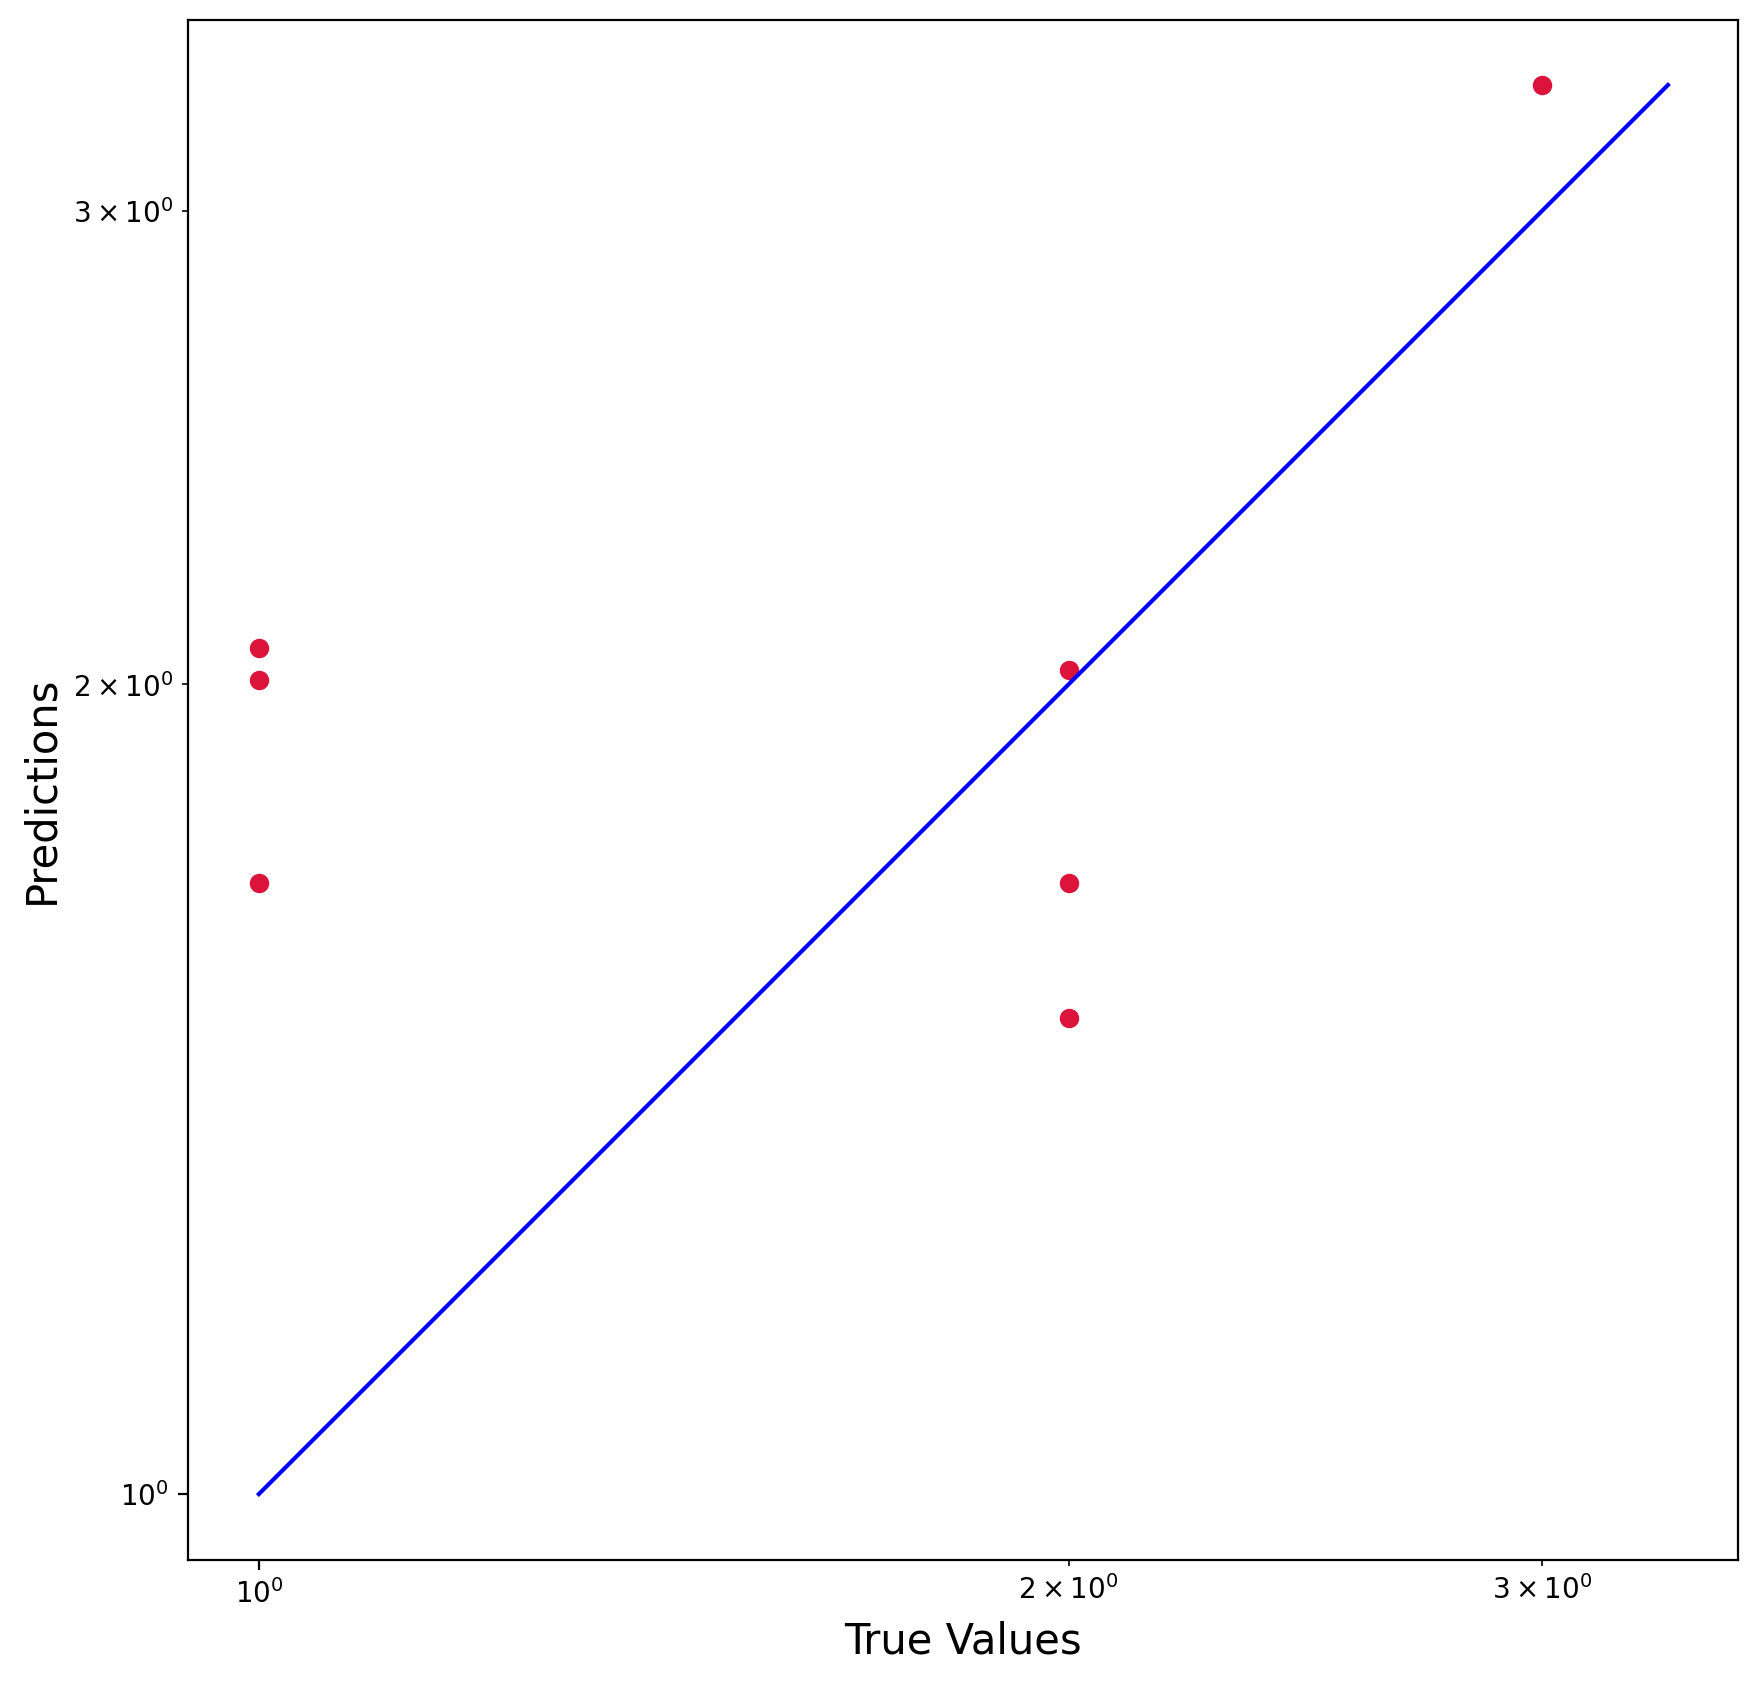

In [40]:
plt.figure(figsize=(10,10))
plt.scatter(test_Y, y_hat, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1=np.max([np.max(y_hat), np.max(test_Y)])
p2=np.min([np.min(y_hat), np.min(test_Y)])
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()
